In [1]:
# Notebook setup
import os
os.chdir('../')
import logging
import numpy as np
import pytorch_lightning as pl
import pandas as pd
import scanpy as sc
logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s'
    )
%load_ext autoreload
%autoreload 2

# assign number of cpus to use as data loaders
n_cpus = 10
seed = 42
model_dir = 'models/run2'
# define label in .obs to classify
cls_label = 'cls_label'
batch_key = 'dataset'

/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_mtx from `

### Load dataset

In [2]:
#metaset_path = '/home/xlv0877/proj_home/ExPert/results/merge/6db565012b360b93/mixscale_filtered_w_emb.h5ad'
#metaset_path = '/home/xlv0877/proj_home/ExPert/results/merge/6db565012b360b93/adata_w_cls_emb.h5ad'
metaset_path = '/home/xlv0877/proj_home/ExPert/results/merge/6db565012b360b93/adata_w_cls_emb_prot.h5ad'

adata = sc.read(metaset_path)

### Setup adata

In [3]:
# Fix cell type column
if 'cell type' in adata.obs.columns:
    adata.obs['celltype'] = adata.obs['cell type'].values

In [4]:
# define all labels to classify on
if 'perturbation_direction' in adata.obs.columns:
    logging.info('Using perturbation direction to classify')
    cls_labels = ['perturbation_direction', 'perturbation']
else:
    cls_labels = ['celltype', 'perturbation_type', 'perturbation']
# define label in .obs to classify
cls_label = 'cls_label'
batch_key = 'dataset'
# create classification label
adata.obs['cls_label'] = adata.obs[cls_labels].agg(';'.join, axis=1)
# add status label (control or perturbed)
adata.obs['is_ctrl'] = adata.obs['perturbation'] == 'control'

2025-06-10 10:30:28,825 - INFO - Using perturbation direction to classify


#### Optional: subset perturbations (for performance sake)

In [5]:
# Take a few perturbations out to predict later
N = 100
M = 10
idx = np.where(adata.obs[cls_labels[-1]].isin(adata.obs[cls_labels[-1]].value_counts()[:N].index))[0]
idx_unseen = np.where(adata.obs[cls_labels[-1]].isin(adata.obs[cls_labels[-1]].value_counts()[N:N+M].index))[0]
unseen_adata = adata[idx_unseen].copy()
adata._inplace_subset_obs(idx)

#### Optional: subset datasets

In [6]:
adata._inplace_subset_obs(adata.obs.dataset.str.startswith('ReplogleWeissman'))

### Filter by mixscale score (optional if already filtered)

In [7]:
# Filter for mixscale score
mst = 2
ms_mask = (adata.obs['mixscale_score'].abs() > mst) | (adata.obs['perturbation']=='control')
adata._inplace_subset_obs(ms_mask)
cpp = adata.obs.perturbation.value_counts()
logging.info(f'Filtering for mixscale score > {mst}, mean number of cells / perturbation: {cpp[1:].mean()}')
logging.info(f'Filtered for {np.sum(ms_mask)}/{len(ms_mask)} cells')

2025-06-10 10:31:06,823 - INFO - Filtering for mixscale score > 2, mean number of cells / perturbation: 925.1475409836065
2025-06-10 10:31:06,824 - INFO - Filtered for 91410/122434 cells


### Subset control cells for each celltype / dataset

In [8]:
from src.sampling import sample_from_ctrl_cells

adata = sample_from_ctrl_cells(
    adata, cls_labels=['celltype', 'perturbation_type', 'perturbation'], n_ctrl=2000
).copy()

2025-06-10 10:31:33,003 - INFO - Resulting set has 57343 cells.


### Remove perturbations that do not have an embedding

In [9]:
logging.info(f'Found {adata.obs.cls_label.nunique()} classes.')
# Either focus on class embedding or gene embedding, should work either way
if 'cls_embedding' in adata.uns:
    embedding_mask = adata.uns['cls_embedding'].sum(axis=1)!=0
    embedding_mask = adata.obs.cls_label.isin(embedding_mask[embedding_mask].index)
elif 'gene_embedding' in adata.obsm:
    # Select cells that have a match in the embedding
    embedding_mask = adata.obsm['gene_embedding'].sum(axis=1).A1!=0
else:
    embedding_mask = None
    logging.info('No embeddings found.')
if embedding_mask is not None:
    adata._inplace_subset_obs((embedding_mask | adata.obs.is_ctrl))
    # Check number of unique perturbations to classify
    logging.info(f'Initializing dataset with {adata.obs.cls_label.nunique()} classes.')

2025-06-10 10:31:37,210 - INFO - Found 62 classes.
2025-06-10 10:31:38,431 - INFO - Initializing dataset with 61 classes.


### Remove control cells

In [24]:
logging.info('Removing control groups.')
adata._inplace_subset_obs(adata.obs.perturbation!='control')
logging.info(f'Model set shape: {adata.shape[0]} cells x {adata.shape[1]} genes.')

2025-06-13 11:05:53,119 - INFO - Removing control groups.
2025-06-13 11:05:54,029 - INFO - Model set shape: 55395 cells x 20960 genes.


### Filter for HVGs

In [25]:
sc.pp.highly_variable_genes(adata, flavor='seurat_v3')
logging.info(f'# hvgs: {adata.var.highly_variable.sum()}')

2025-06-13 11:07:10,400 - INFO - # hvgs: 2000


### Filter for HVGs (pre-existing)

In [22]:
adata.obs.celltype.value_counts()

NameError: name 'adata' is not defined

In [19]:
# Select pre-calculated hvgs
hvg_dir = os.path.join(os.path.dirname(metaset_path), 'hvg')
hvgs = set()
for p in os.listdir(hvg_dir):
    idx = p.split('_hvgs')[0]
    fp = os.path.join(hvg_dir, p)
    _hvg = pd.read_csv(fp, index_col=0)
    hvgs.update(_hvg[_hvg.highly_variable==1].index)
adata.var['highly_variable'] = adata.var.index.isin(hvgs)

2025-05-26 11:06:21,034 - INFO - #hvgs: 13521


In [8]:
# Select 2000 hvgs per dataset
degs_per_ct = 2000
max_degs = 20_000
n_degs = adata.obs.celltype.nunique() * degs_per_ct
if n_degs > adata.n_vars:
    n_degs = max_degs
sc.pp.highly_variable_genes(
    adata, flavor='seurat_v3', n_top_genes=n_degs
)

2025-05-25 01:31:07,868 - INFO - HVGs: 12000/54534


In [20]:
# subset adata to highly variable genes
logging.info(f'HVGs: {np.sum(adata.var.highly_variable)}/{adata.n_vars}')
adata._inplace_subset_var(adata.var.highly_variable)

2025-05-26 11:06:53,517 - INFO - HVGs: 13521/54534


### Set model set

In [10]:
# Remove genes with no counts (zero-padded)
sc.pp.filter_genes(adata, min_counts=1)
sc.pp.filter_cells(adata, min_counts=1)

In [11]:
# remove perturbations with less than minimum amount of cells
min_cells = 50
p_summary = adata.obs.cls_label.value_counts()
valid_perturbations = p_summary[p_summary >= min_cells].index
adata._inplace_subset_obs(adata.obs.cls_label.isin(valid_perturbations))

#### Save training data

In [12]:
# Cache dataset
adata.write_h5ad('data/model_set.h5ad')

... storing 'cls_label' as categorical


#### Init model set

In [13]:
# choose set to train on
copy = False
likelihood = 'zinb'

if copy:
    logging.info('Copying adata (will double the RAM usage)')
    model_set = adata.copy()
else:
    model_set = adata

if likelihood == 'normal':
    logging.info('Applying log1p and scaling data to force normal distribution')
    sc.pp.log1p(model_set)
    sc.pp.scale(model_set)
# Check number of unique perturbations to classify
logging.info(f'Initializing dataset with {model_set.obs.cls_label.nunique()} classes')
logging.info(f'{model_set.obs[cls_labels[1:]].drop_duplicates().shape[0]} unique perturbations')
logging.info(f'{model_set.obs[cls_labels[-1]].nunique()} unique gene-perturbations')
logging.info(f'{model_set.obs["celltype"].nunique()} unique cell types')
logging.info(f'Mean number of cells / perturbation {model_set.obs.cls_label.value_counts().mean()}')
logging.info(f'Adata shape: {model_set.shape}')

2025-06-10 10:31:51,124 - INFO - Initializing dataset with 57 classes
2025-06-10 10:31:51,126 - INFO - 57 unique perturbations
2025-06-10 10:31:51,126 - INFO - 57 unique gene-perturbations
2025-06-10 10:31:51,127 - INFO - 4 unique cell types
2025-06-10 10:31:51,127 - INFO - Mean number of cells / perturbation 987.7894736842105
2025-06-10 10:31:51,128 - INFO - Adata shape: (56304, 20960)


### Cache model set

In [2]:
model_set = sc.read('data/model_set.h5ad')
# define all labels to classify on
if 'perturbation_direction' in model_set.obs.columns:
    logging.info('Using perturbation direction to classify')
    cls_labels = ['perturbation_direction', 'perturbation']
else:
    cls_labels = ['celltype', 'perturbation_type', 'perturbation']
likelihood = 'zinb'
# Check number of unique perturbations to classify
logging.info(f'Initializing dataset with {model_set.obs.cls_label.nunique()} classes')
logging.info(f'{model_set.obs[cls_labels[1:]].drop_duplicates().shape[0]} unique perturbations')
logging.info(f'{model_set.obs[cls_labels[-1]].nunique()} unique gene-perturbations')
logging.info(f'{model_set.obs["celltype"].nunique()} unique cell types')
logging.info(f'Mean number of cells / perturbation {model_set.obs.cls_label.value_counts().mean()}')
logging.info(f'Adata shape: {model_set.shape}')

2025-06-20 10:49:29,063 - INFO - Using perturbation direction to classify
2025-06-20 10:49:29,064 - INFO - Initializing dataset with 55 classes
2025-06-20 10:49:29,065 - INFO - 55 unique perturbations
2025-06-20 10:49:29,066 - INFO - 55 unique gene-perturbations
2025-06-20 10:49:29,066 - INFO - 4 unique cell types
2025-06-20 10:49:29,067 - INFO - Mean number of cells / perturbation 992.9636363636364
2025-06-20 10:49:29,067 - INFO - Adata shape: (54613, 4000)


### Base hyperparameters

In [3]:
import torch
from src.models._gedvi import GEDVI
from src.plotting import get_model_results

# set model dir
class_labels = model_set.obs[cls_label].unique()
n_labels = len(class_labels)-1 if 'unknown' in class_labels else len(class_labels)  
# set scale for kl divergence
recon_weight = 1
klr = 1
g_weight = 0      # Pair-wise distance stuff
contrastive_y = 0.25
contrastive_loss_weight = 1
contrastive_margin = 1
g_classification_weight = 1
cr = 1
adjust_by_mean = True

# hyperparameters for model
cls_params = {
    'n_hidden': 128, 'n_layers': 1, 'dropout_rate': 0.1
}
gedvae_params = {
    'n_hidden': 256,
    'n_latent': 128,
    'n_latent_g': 128,
    'n_layers': 1,
    'n_layers_encoder_g': 1,
    'dropout_rate': 0.2,
    'dropout_rate_encoder_g': 0.1,
    'dispersion': 'gene',
    'use_batch_norm': 'both',
    'gene_likelihood': likelihood,
    'linear_classifier': False,
    'classifier_parameters': cls_params,
    'log_variational': likelihood == 'zinb',
    'normalize_recon_loss': None,
    'g_weight': g_weight,
    'g_activation': None,
    'contrastive_y': contrastive_y,
    'contrastive_loss_weight': contrastive_loss_weight,
    'contrastive_margin': contrastive_margin,
    'adjust_by_mean': adjust_by_mean,
    'g_classification_weight': g_classification_weight
}

tensor_dir = os.path.join(model_dir, f'n_{n_labels}')

data_params = {
    'train_size': 0.8,
    'batch_size': 128,
    'num_workers': 1,
    'shuffle_train': True,
}
plan_params = {
    'lr': 1e-3,
    'weight_decay': 1e-6,
    'lr_scheduler_metric': 'elbo_validation',
    'lr_patience': 30,
    'plot_cm': False, 'plot_umap': False
}
train_params = {
    'max_epochs': 85,
    'early_stopping': True,
    'check_val_every_n_epoch': 1,
    'logger': pl.loggers.TensorBoardLogger(tensor_dir),
    'plan_kwargs': plan_params,
}
# Define covariates, set celltype as covariate
cat_covs = None
cont_covs = None

torch.set_float32_matmul_precision('medium')
#torch.manual_seed(seed)
#np.random.seed(seed)

### Train different models

#### Step 1: Reconstruction only

In [48]:
from src.utils.activations import ScaleByFactor

# Set logging directory
step_model_dir = os.path.join(model_dir, 'rl+kl')
train_params['logger'] = pl.loggers.TensorBoardLogger(step_model_dir)
# Set parameters
plan_params['lr'] = 1e-3
plan_params['lr_patience'] = 30
plan_params['n_epochs_kl_warmup'] = 400               # KL should already be warmed up
plan_params['min_kl_weight'] = 0                      # Start KL at previous scvi max
plan_params['max_kl_weight'] = 1                      # Set max
plan_params['n_epochs_cls_warmup'] = 200              # Gradually increase classification loss
plan_params['n_epochs_cls_stall'] = 0
plan_params['min_cls_weight'] = 0
plan_params['max_cls_weight'] = 0
plan_params['use_posterior_mean'] = 'val'
plan_params['n_epochs_contr_warmup'] = 120              # Gradually increase classification loss
plan_params['n_epochs_contr_stall'] = 0
plan_params['min_contr_weight'] = 0
plan_params['max_contr_weight'] = 0
plan_params['lr_scheduler_metric'] = 'elbo_validation'
gedvae_params['decode_g'] = False                     # Decode zg latent space and add a reconstruction loss an that
gedvae_params['emb_likelihood'] = 'normal'
gedvae_params['use_x_in_zg'] = False                     # Decode g together with x
gedvae_params['g_activation'] = ScaleByFactor(10)        # Scale embedding by factor to push values further from 0 (control)
gedvae_params['g_classification_weight'] = 0         # Classification loss (zxg)
gedvae_params['contrastive_loss_weight'] = 0       # Classification loss (zxg)
gedvae_params['contrastive_y'] = 0                    # Try different settings here (0=similar, 1=dissimilar)
gedvae_params['use_attention_encoder'] = False
gedvae_params['dropout_rate'] = 0.2
gedvae_params['dropout_rate_encoder_g'] = 0.1
gedvae_params['l1_lambda'] = 1e-4
train_params['plan_kwargs'] = plan_params          # Update plan params
train_params['early_stopping_monitor'] = 'elbo_validation'
train_params['early_stopping_patience'] = 12
train_params['early_stopping'] = True
train_params['max_epochs'] = 200
# Setup anndata with model
GEDVI.setup_anndata(
    model_set, batch_key=batch_key, labels_key=cls_label, unlabeled_category='unknown',
    categorical_covariate_keys=cat_covs, gene_emb_obsm_key=None
)
# Training parameters
gedvae = GEDVI(model_set, **gedvae_params.copy())
# Train the model
logging.info(f'Running at: {step_model_dir}')
gedvae.train(data_params=data_params.copy(), model_params=gedvae_params.copy(), train_params=train_params.copy(), return_runner=False)
# Save results to lightning directory
results, latent = get_model_results(
    model=gedvae, cls_labels=cls_labels, log_dir=step_model_dir, plot=True
)

/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
2025-05-27 00:32:27,806 - INFO - Running at: models/disentangle_losses/rl+kl
2025-05-27 00:32:27,806 - INFO - Epochs suggested: 54, training for 200 epochs.
INFO: GPU available: True (cuda), used: True
2025-05-27 00:32:27,991 - INFO - GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
2025-05-27 00:32:27,991 - INFO - TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
2025-05-27 00:32:27,992 - INFO - HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2025-05-27 00:32:28,000 - INFO - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/pytorch_lightning/core/saving.py:363: Skipping 'train_params' parameter because it is not possible to safel

Training:   0%|          | 0/200 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
2025-05-27 02:32:54,958 - INFO - `Trainer.fit` stopped: `max_epochs=200` reached.
2025-05-27 02:32:57,893 - INFO - Processing train set


UnboundLocalError: cannot access local variable 'qzgm' where it is not associated with a value

#### Step 2: Incl. KL loss

INFO     Generating sequential column names                                                                        


2025-05-15 12:59:02,016 - INFO - Running at: models/disentangle_losses/rl+kl
2025-05-15 12:59:02,017 - INFO - Epochs suggested: 120, training for 120 epochs.
INFO: GPU available: True (cuda), used: True
2025-05-15 12:59:02,355 - INFO - GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
2025-05-15 12:59:02,355 - INFO - TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
2025-05-15 12:59:02,355 - INFO - HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2025-05-15 12:59:02,361 - INFO - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/pytorch_lightning/core/saving.py:363: Skipping 'train_params' parameter because it is not possible to safely dump to YAML.
INFO: SLURM auto-requeueing enabled. Setting signal handlers.
2025-05-15 12:59:02,372 - INFO - SLURM auto-requeueing enabled. Setting signal handlers.
/home/xlv0877/.conda/envs/pydl/lib/p

Training:   0%|          | 0/120 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=120` reached.
2025-05-15 13:17:24,561 - INFO - `Trainer.fit` stopped: `max_epochs=120` reached.
2025-05-15 13:17:24,903 - INFO - Processing train set
2025-05-15 13:17:34,775 - INFO - Calculating latent neighbors
2025-05-15 13:17:39,463 - INFO - Calculating latent umap
2025-05-15 13:18:12,695 - INFO - Plotting train for label: celltype
... storing 'cls_label' as categorical
... storing 'status' as categorical
... storing 'scanvi_predictions' as categorical
2025-05-15 13:18:14,395 - INFO - Plotting train for label: perturbation_type
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
2025-05-15 13:18:15,886 - INFO - Plotting train for label: perturbation
2025-05-15 13:18:19,080 - INFO - Plotting train for label: datas

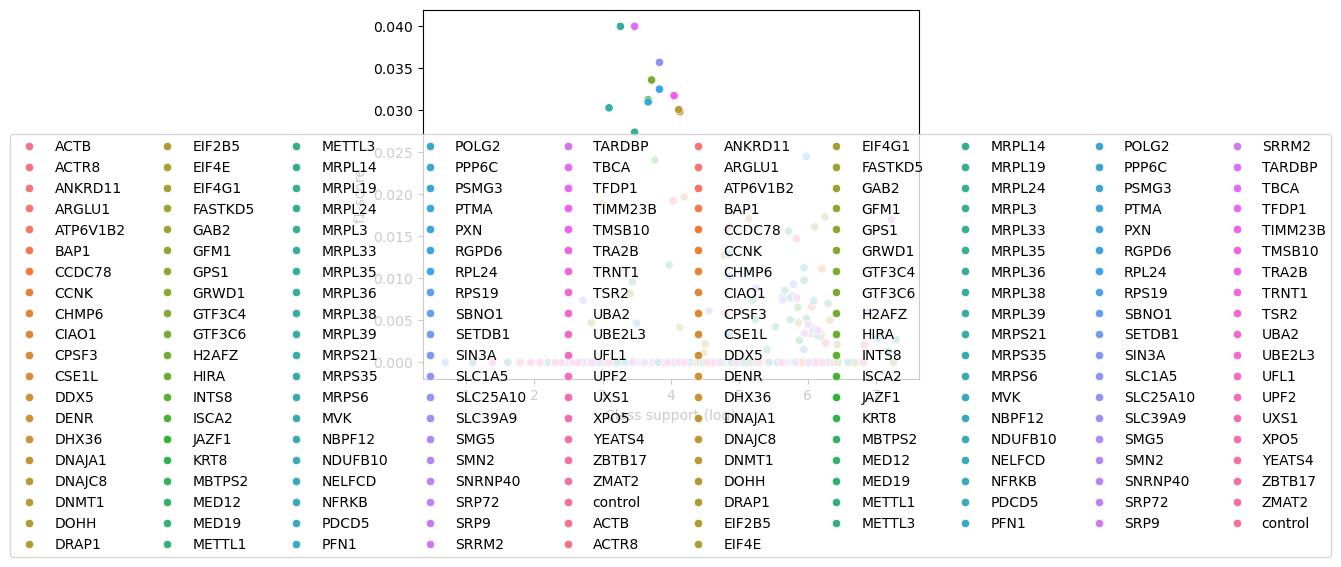

In [30]:
# Set logging directory
step_model_dir = os.path.join(model_dir, 'rl+kl')
train_params['logger'] = pl.loggers.TensorBoardLogger(step_model_dir)
# Set parameters
plan_params['kl_weight'] = 1                       # KL divergence loss
plan_params['lr'] = 1e-3
plan_params['kl_warmup'] = False
plan_params['anneal_steps'] = 5000
plan_params['classification_ratio'] = 0            # Classification loss (zx)
gedvae_params['g_classification_weight'] = 0       # Classification loss (zxg)
gedvae_params['contrastive_loss_weight'] = 0       # Classification loss (zxg)
train_params['plan_kwargs'] = plan_params.copy()          # Update plan params
train_params['max_epochs'] = 120
# Setup anndata with model
GEDVI.setup_anndata(
    model_set, batch_key=batch_key, labels_key=cls_label, unlabeled_category='unknown',
    categorical_covariate_keys=cat_covs,
)
# Training parameters
base_model = GEDVI(model_set, **gedvae_params.copy())
# Train the model
logging.info(f'Running at: {step_model_dir}')
base_model.train(data_params=data_params.copy(), model_params=gedvae_params.copy(), train_params=train_params.copy(), return_runner=False)
# Save results to lightning directory
results, latent = get_model_results(
    model=base_model, cls_labels=cls_labels, log_dir=step_model_dir, plot=True
)

In [24]:
# Save model as base reconstruction
base_model = gedvae

#### Step 3: Incl. Classification loss

In [36]:
from src.utils.activations import ScaleByFactor

# Set logging directory
step_model_dir = os.path.join(model_dir, 'rl+kl+c')
train_params['logger'] = pl.loggers.TensorBoardLogger(step_model_dir)
# Set parameters
plan_params['lr'] = 1e-3
plan_params['lr_patience'] = 30
plan_params['n_epochs_kl_warmup'] = 400               # KL should already be warmed up
plan_params['min_kl_weight'] = 0                      # Start KL at previous scvi max
plan_params['max_kl_weight'] = 1                      # Set max
plan_params['n_epochs_cls_warmup'] = 200              # Gradually increase classification loss
plan_params['n_epochs_cls_stall'] = 0
plan_params['min_cls_weight'] = 1e-9
plan_params['max_cls_weight'] = 1
plan_params['use_posterior_mean'] = 'val'
plan_params['n_epochs_contr_warmup'] = 120              # Gradually increase classification loss
plan_params['n_epochs_contr_stall'] = 40
plan_params['min_contr_weight'] = 0
plan_params['max_contr_weight'] = 0
plan_params['lr_scheduler_metric'] = 'validation_classification_loss'
gedvae_params['decode_g'] = False                     # Decode zg latent space and add a reconstruction loss an that
gedvae_params['emb_likelihood'] = 'normal'
gedvae_params['use_x_in_zg'] = False                     # Decode g together with x
gedvae_params['g_activation'] = ScaleByFactor(10)        # Scale embedding by factor to push values further from 0 (control)
gedvae_params['g_classification_weight'] = 0         # Classification loss (zxg)
gedvae_params['contrastive_loss_weight'] = 0       # Classification loss (zxg)
gedvae_params['contrastive_y'] = 0                    # Try different settings here (0=similar, 1=dissimilar)
gedvae_params['use_attention_encoder'] = False
gedvae_params['dropout_rate'] = 0.2
gedvae_params['dropout_rate_encoder_g'] = 0.1
gedvae_params['l1_lambda'] = 1e-4
train_params['plan_kwargs'] = plan_params          # Update plan params
train_params['early_stopping_monitor'] = 'validation_classification_loss'
train_params['early_stopping_patience'] = 12
train_params['early_stopping'] = True
train_params['max_epochs'] = 200
# Setup anndata with model
GEDVI.setup_anndata(
    model_set, batch_key=batch_key, labels_key=cls_label, unlabeled_category='unknown',
    categorical_covariate_keys=cat_covs, gene_emb_obsm_key=None
)
# Training parameters
gedvae = GEDVI(model_set, **gedvae_params.copy())
# Train the model
logging.info(f'Running at: {step_model_dir}')
gedvae.train(data_params=data_params.copy(), model_params=gedvae_params.copy(), train_params=train_params.copy(), return_runner=False)
# Save results to lightning directory
results, latent = get_model_results(
    model=gedvae, cls_labels=cls_labels, log_dir=step_model_dir, plot=True
)

/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
2025-06-17 17:07:30,314 - INFO - Running at: models/contrastive_hp_grid/rl+kl+c
2025-06-17 17:07:30,314 - INFO - Epochs suggested: 146, training for 200 epochs.
INFO: GPU available: True (cuda), used: True
2025-06-17 17:07:30,807 - INFO - GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
2025-06-17 17:07:30,807 - INFO - TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
2025-06-17 17:07:30,807 - INFO - HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2025-06-17 17:07:30,812 - INFO - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/pytorch_lightning/core/saving.py:363: Skipping 'train_params' parameter because it is not possible to s

Training:   0%|          | 0/200 [00:00<?, ?it/s]

> /projects/b1042/GoyalLab/lschwartz/dl/src/_train/plan.py(341)training_step()
    339         import pdb
    340         pdb.set_trace()
--> 341         """Training step for semi-supervised training."""
    342         # Potentially dangerous if batch is from a single dataloader with two keys
    343         if len(batch) == 2:



ipdb>  full_dataset = batch[0]
ipdb>  full_dataset['X'].shape


torch.Size([128, 4000])


ipdb>  exit


#### Step 3.1: Use Pre-trained base model

In [4]:
# pre-calculate max epochs, set minimum to 10
from scvi.model._utils import get_max_epochs_heuristic

max_epochs = int(np.max([get_max_epochs_heuristic(model_set.n_obs), 40]))
logging.info(f'Training for {max_epochs} epochs')

2025-06-13 10:35:16,291 - INFO - Training for 142 epochs


In [5]:
from scvi.model._scvi import SCVI
import scipy.sparse as sp

scvi_model_dir = os.path.join(model_dir, 'scvi', str(n_labels))

if not isinstance(model_set.X, sp.csr_matrix):
    logging.info('Formating to CSR')
    model_set.X = sp.csr_matrix(model_set.X)
# Setup anndata with model
SCVI.setup_anndata(
    model_set, batch_key=batch_key
)
scvi = SCVI(model_set, n_hidden=256, n_latent=128, n_layers=1, dropout_rate=0.2)
scvi.train(max_epochs=max_epochs, early_stopping=True, logger=pl.loggers.TensorBoardLogger(scvi_model_dir))

2025-06-13 10:35:31,838 - INFO - Formating to CSR
INFO: GPU available: True (cuda), used: True
2025-06-13 10:35:35,942 - INFO - GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
2025-06-13 10:35:35,943 - INFO - TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
2025-06-13 10:35:35,943 - INFO - HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2025-06-13 10:35:36,970 - INFO - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: SLURM auto-requeueing enabled. Setting signal handlers.
2025-06-13 10:35:37,253 - INFO - SLURM auto-requeueing enabled. Setting signal handlers.
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/home/

Training:   0%|          | 0/142 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=142` reached.
2025-06-13 10:43:03,781 - INFO - `Trainer.fit` stopped: `max_epochs=142` reached.


In [6]:
# Save latest scvi model to cache
scvi.save(scvi_model_dir, save_anndata=False, overwrite=True)

##### Plot latent space

In [19]:
model_set.obs['split'] = 'train'
model_set.obs.iloc[scvi.validation_indices,np.where('split'==model_set.obs.columns)[0]] = 'val'

In [7]:
# Check out latent space
model_set.obsm['X_scVI'] = scvi.get_latent_representation()

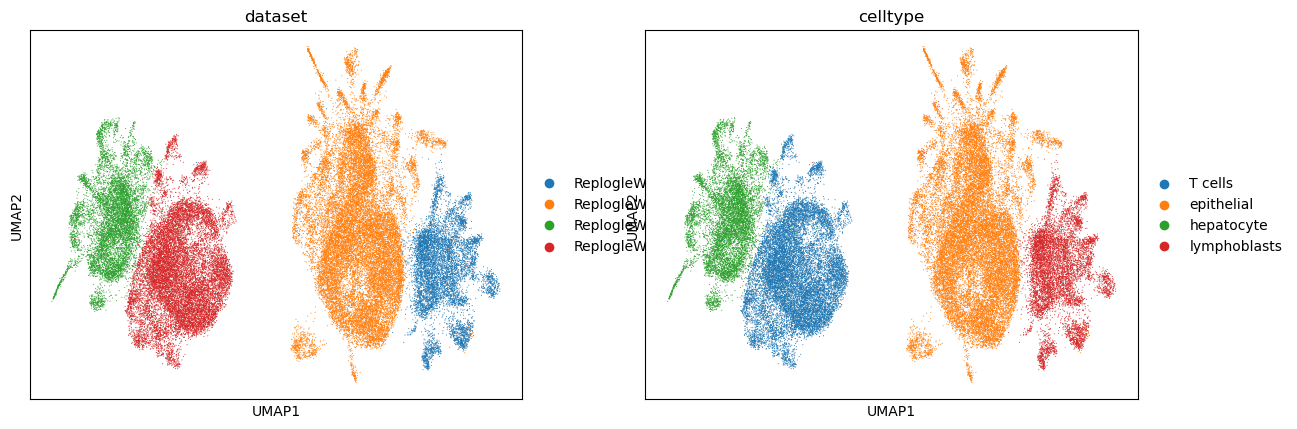

In [9]:
sc.pp.neighbors(model_set, use_rep='X_scVI')
sc.tl.umap(model_set)
sc.pl.umap(model_set, color=['dataset', 'celltype'])

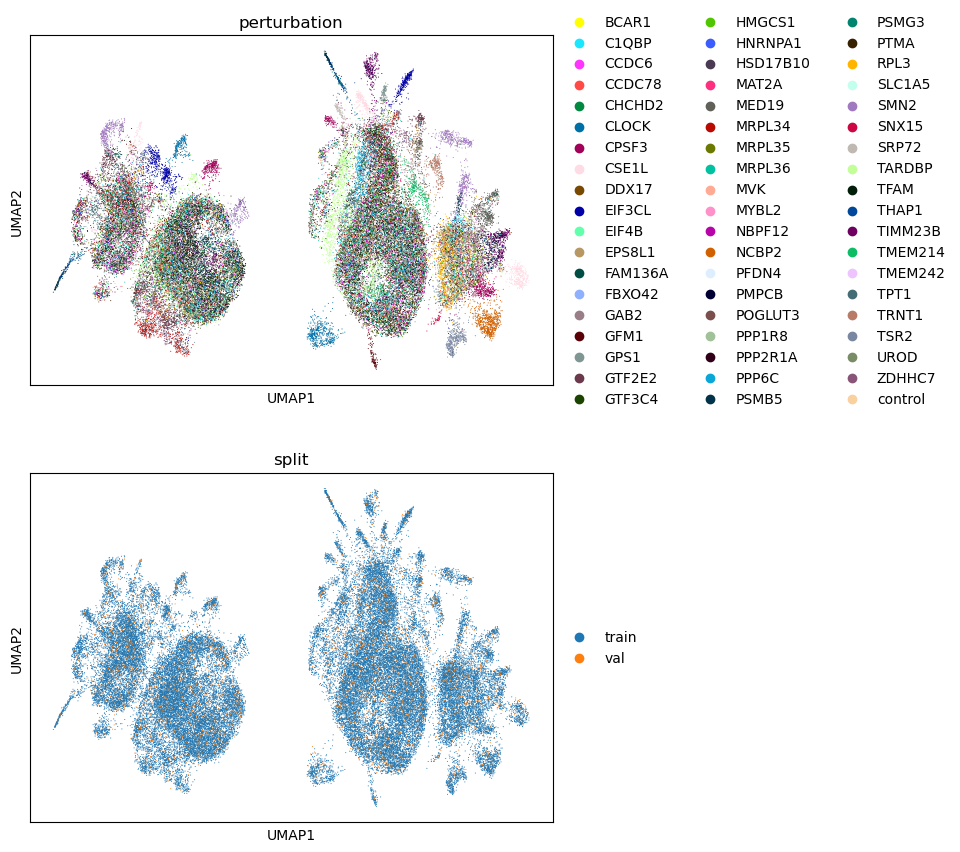

In [21]:
sc.pl.umap(model_set, color=['perturbation', 'split'], ncols=1)

In [11]:
sc.tl.leiden(model_set)
logging.info(f'Number of leiden clusters: {model_set.obs.leiden.nunique()}')

/tmp/ipykernel_3324884/3240147150.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(model_set)
2025-06-13 10:44:35,782 - INFO - Number of leiden clusters: 36


#### Step 3.2: Pre-train + scanVI

In [33]:
# Train scanvi
from scvi.model._scanvi import SCANVI

step_model_dir = os.path.join(model_dir, 'scvi+scanvi')
# Setup anndata with model
SCANVI.from_scvi_model(
    scvi, labels_key=cls_label, unlabeled_category='unknown'
)
scanvi = SCANVI(model_set, n_hidden=128, n_latent=100, n_layers=1)
scanvi.train(logger=pl.loggers.TensorBoardLogger(step_model_dir), check_val_every_n_epoch=1)

INFO     Training for 118 epochs.                                                                                  


INFO: GPU available: True (cuda), used: True
2025-05-20 18:23:48,133 - INFO - GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
2025-05-20 18:23:48,134 - INFO - TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
2025-05-20 18:23:48,134 - INFO - HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2025-05-20 18:23:48,140 - INFO - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: SLURM auto-requeueing enabled. Setting signal handlers.
2025-05-20 18:23:48,146 - INFO - SLURM auto-requeueing enabled. Setting signal handlers.
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packa

Training:   0%|          | 0/118 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=118` reached.
2025-05-20 18:50:46,879 - INFO - `Trainer.fit` stopped: `max_epochs=118` reached.


2025-05-15 22:04:28,576 - INFO - Processing train set
2025-05-15 22:04:37,376 - INFO - Calculating latent neighbors
2025-05-15 22:04:44,034 - INFO - Calculating latent umap
2025-05-15 22:05:17,811 - INFO - Plotting train for label: celltype
... storing 'cls_label' as categorical
... storing 'status' as categorical
... storing 'scanvi_predictions' as categorical
2025-05-15 22:05:19,487 - INFO - Plotting train for label: perturbation_type
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
2025-05-15 22:05:20,976 - INFO - Plotting train for label: perturbation
2025-05-15 22:05:24,204 - INFO - Plotting train for label: dataset
2025-05-15 22:05:28,540 - INFO - Processing val set
2025-05-15 22:05:29,566 - INFO - Calculating latent neighbors
2025-05-15 22:05:29,

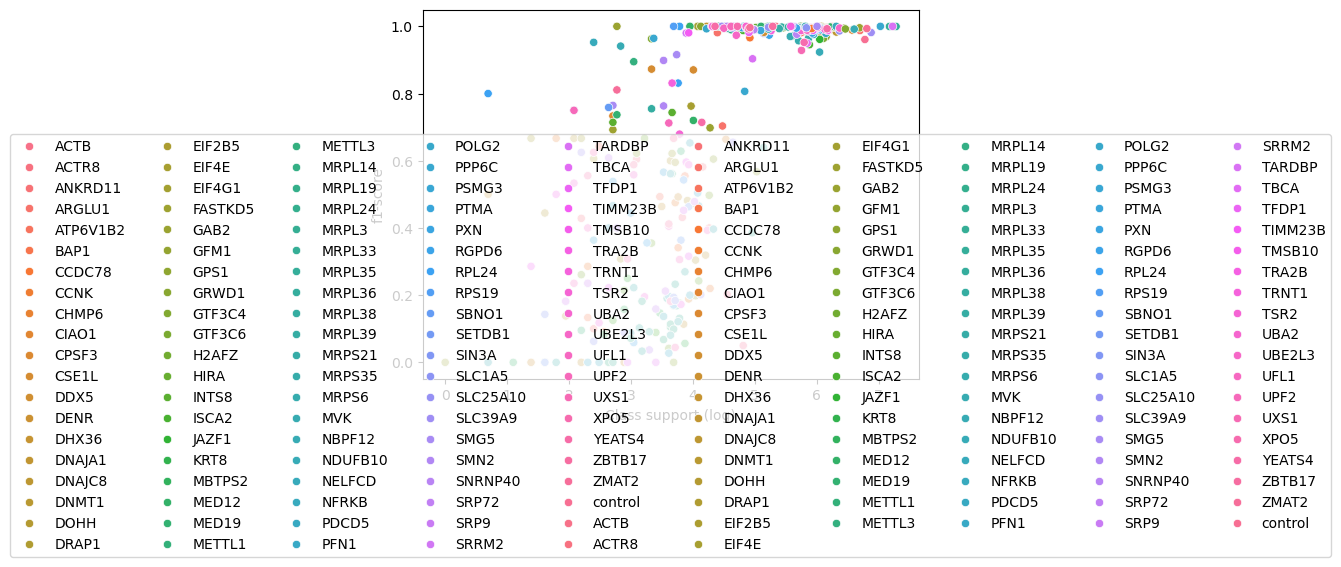

In [48]:
results, latent = get_model_results(
    model=scanvi, cls_labels=cls_labels, log_dir=step_model_dir, plot=True
)

#### Step 3.3: Pre-Train + classifier

In [12]:
# Set logging directory
step_model_dir = os.path.join(model_dir, 'scvi+rl+kl+c')
train_params['logger'] = pl.loggers.TensorBoardLogger(step_model_dir)
# Set parameters
data_params['num_workers'] = 1
plan_params['lr'] = 1e-4
gedvae_params['decode_g'] = False                     # Decode zg latent space
plan_params['n_epochs_kl_warmup'] = 400               # KL should already be warmed up
plan_params['min_kl_weight'] = 0                      # Set upper and lower bound for KL
plan_params['max_kl_weight'] = 1
plan_params['n_epochs_cls_warmup'] = 50              # Gradually increase classification loss
plan_params['n_epochs_cls_stall'] = 0
plan_params['min_cls_weight'] = 0
plan_params['max_cls_weight'] = 1
plan_params['lr_scheduler_metric'] = 'validation_classification_loss'
gedvae_params['g_classification_weight'] = 0       # Classification loss (zxg)
gedvae_params['contrastive_loss_weight'] = 0       # Classification loss (zxg)
train_params['plan_kwargs'] = plan_params          # Update plan params
train_params['max_epochs'] = 120
train_params['early_stopping'] = False
# Setup anndata with model
gedvae = GEDVI.from_scvi_model(
    scvi,
    labels_key=cls_label, unlabeled_category='unknown',
    **gedvae_params.copy()
)
# Train the model
logging.info(f'Running at: {step_model_dir}')
gedvae.train(data_params=data_params.copy(), model_params=gedvae_params.copy(), train_params=train_params.copy(), return_runner=False)
# Save results to lightning directory
results, latent = get_model_results(
    model=gedvae, cls_labels=cls_labels, log_dir=step_model_dir, plot=True
)

/tmp/ipykernel_3324884/1592086071.py:22: UserWarning: Ignoring param 'n_hidden' as it was already passed in to pretrained SCVI model with value 256.
  gedvae = GEDVI.from_scvi_model(
/tmp/ipykernel_3324884/1592086071.py:22: UserWarning: Ignoring param 'n_latent' as it was already passed in to pretrained SCVI model with value 128.
  gedvae = GEDVI.from_scvi_model(
/tmp/ipykernel_3324884/1592086071.py:22: UserWarning: Ignoring param 'n_layers' as it was already passed in to pretrained SCVI model with value 1.
  gedvae = GEDVI.from_scvi_model(
/tmp/ipykernel_3324884/1592086071.py:22: UserWarning: Ignoring param 'dropout_rate' as it was already passed in to pretrained SCVI model with value 0.2.
  gedvae = GEDVI.from_scvi_model(
/tmp/ipykernel_3324884/1592086071.py:22: UserWarning: Ignoring param 'dispersion' as it was already passed in to pretrained SCVI model with value gene.
  gedvae = GEDVI.from_scvi_model(
/tmp/ipykernel_3324884/1592086071.py:22: UserWarning: Ignoring param 'gene_likel

Training:   0%|          | 0/120 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x1479d1abd940>
Traceback (most recent call last):
  File "/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1568, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/xlv0877/.conda/envs/pydl/lib/python3.11/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/xlv0877/.conda/envs/pydl/lib/python3.11/multiprocessing/popen_fork.py", line 43, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/xlv0877/.conda/envs/pydl/lib/python3.11/multiprocessing/popen_fork.py", line 27, in poll
    pid, sts = os.waitpid(self.pid, flag)
 

FileNotFoundError: [Errno 2] No such file or directory

#### Step 4: Pre-Train + zg classifier

INFO     Generating sequential column names                                                                        


/tmp/ipykernel_3971745/289496423.py:16: UserWarning: Ignoring param 'n_hidden' as it was already passed in to pretrained SCVI model with value 128.
  gedvae = GEDVI.from_scvi_model(
/tmp/ipykernel_3971745/289496423.py:16: UserWarning: Ignoring param 'n_latent' as it was already passed in to pretrained SCVI model with value 100.
  gedvae = GEDVI.from_scvi_model(
/tmp/ipykernel_3971745/289496423.py:16: UserWarning: Ignoring param 'n_layers' as it was already passed in to pretrained SCVI model with value 1.
  gedvae = GEDVI.from_scvi_model(
/tmp/ipykernel_3971745/289496423.py:16: UserWarning: Ignoring param 'dropout_rate' as it was already passed in to pretrained SCVI model with value 0.1.
  gedvae = GEDVI.from_scvi_model(
/tmp/ipykernel_3971745/289496423.py:16: UserWarning: Ignoring param 'dispersion' as it was already passed in to pretrained SCVI model with value gene.
  gedvae = GEDVI.from_scvi_model(
/tmp/ipykernel_3971745/289496423.py:16: UserWarning: Ignoring param 'gene_likelihood'

Training:   0%|          | 0/80 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=80` reached.
2025-05-13 14:34:20,305 - INFO - `Trainer.fit` stopped: `max_epochs=80` reached.
2025-05-13 14:34:20,692 - INFO - Processing train set
2025-05-13 14:34:30,739 - INFO - Calculating latent neighbors
2025-05-13 14:34:36,436 - INFO - Calculating latent umap
2025-05-13 14:35:11,638 - INFO - Plotting train for label: celltype
... storing 'cls_label' as categorical
... storing 'status' as categorical
... storing 'scanvi_predictions' as categorical
2025-05-13 14:35:13,299 - INFO - Plotting train for label: perturbation_type
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
2025-05-13 14:35:14,787 - INFO - Plotting train for label: perturbation
2025-05-13 14:35:17,926 - INFO - Plotting train for label: dataset

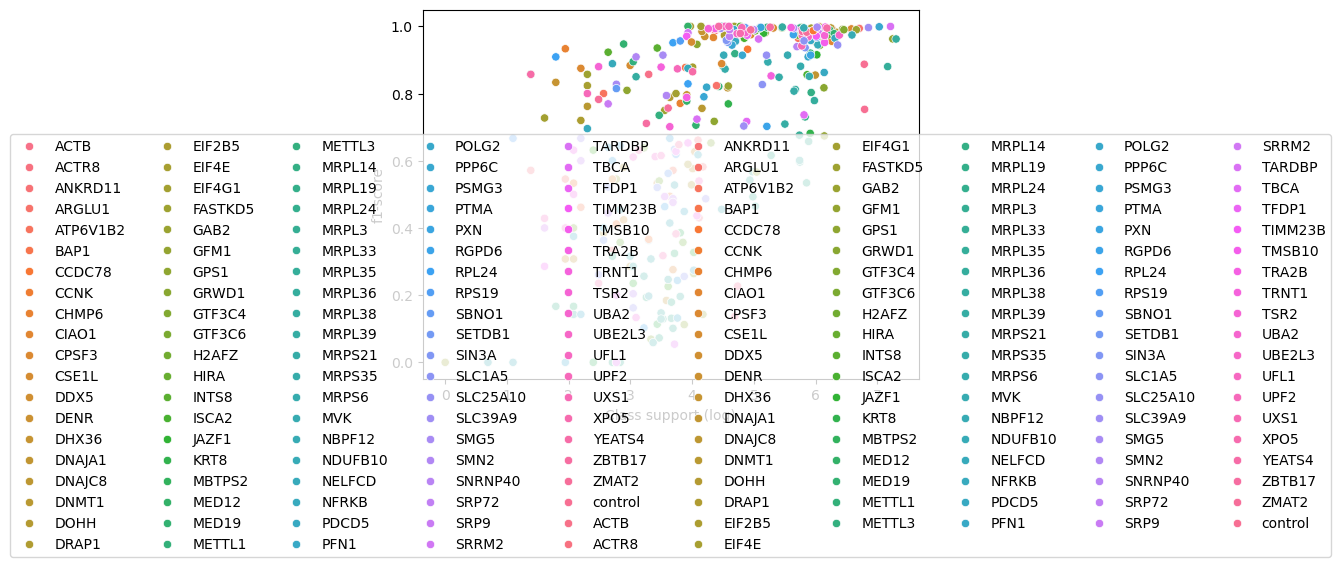

In [73]:
# Set logging directory
step_model_dir = os.path.join(model_dir, 'scvi+rl+kl+c+czg')
train_params['logger'] = pl.loggers.TensorBoardLogger(step_model_dir)
# Set parameters
data_params['num_workers'] = 1
plan_params['lr'] = 1e-4
plan_params['kl_weight'] = 1                       # KL divergence loss
plan_params['classification_ratio'] = 1            # Classification loss (zx)
plan_params['lr_scheduler_metric'] = 'validation_classification_loss'
gedvae_params['g_classification_weight'] = 0       # Classification loss (zxg)
gedvae_params['contrastive_loss_weight'] = 0       # Classification loss (zxg)
train_params['plan_kwargs'] = plan_params          # Update plan params
train_params['max_epochs'] = 80
# Setup anndata with model
gedvae = GEDVI.from_scvi_model(
    scvi,
    labels_key=cls_label, unlabeled_category='unknown',
    **gedvae_params.copy()
)
# Train the model
logging.info(f'Running at: {step_model_dir}')
gedvae.train(data_params=data_params.copy(), model_params=gedvae_params.copy(), train_params=train_params.copy(), return_runner=False)
# Save results to lightning directory
results, latent = get_model_results(
    model=gedvae, cls_labels=cls_labels, log_dir=step_model_dir, plot=True
)

#### Step 5.1 Switch KL for contrastive loss

INFO     Generating sequential column names                                                                        


2025-05-26 20:26:33,108 - INFO - Running at: models/disentangle_losses/rl+kl+c+cl
2025-05-26 20:26:33,108 - INFO - Epochs suggested: 54, training for 200 epochs.
INFO: GPU available: True (cuda), used: True
2025-05-26 20:26:33,249 - INFO - GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
2025-05-26 20:26:33,251 - INFO - TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
2025-05-26 20:26:33,252 - INFO - HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2025-05-26 20:26:33,259 - INFO - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/pytorch_lightning/core/saving.py:363: Skipping 'train_params' parameter because it is not possible to safely dump to YAML.
INFO: SLURM auto-requeueing enabled. Setting signal handlers.
2025-05-26 20:26:33,286 - INFO - SLURM auto-requeueing enabled. Setting signal handlers.
/home/xlv0877/.conda/envs/pydl/l

Training:   0%|          | 0/200 [00:00<?, ?it/s]

2025-05-26 21:00:00,445 - INFO - Processing train set


Monitored metric validation_classification_loss did not improve in the last 12 records. Best score: 105.891. Signaling Trainer to stop.


2025-05-26 21:00:14,417 - INFO - Calculating latent neighbors
2025-05-26 21:00:25,646 - INFO - Calculating latent umap
2025-05-26 21:01:36,753 - INFO - Plotting train for label: celltype
... storing 'cls_label' as categorical
... storing 'status' as categorical
... storing 'cls_prediction' as categorical
2025-05-26 21:01:39,228 - INFO - Plotting train for label: perturbation_type
2025-05-26 21:01:41,578 - INFO - Plotting train for label: perturbation
2025-05-26 21:01:45,260 - INFO - Plotting train for label: dataset
2025-05-26 21:01:49,869 - INFO - Calculating latent neighbors
2025-05-26 21:01:58,963 - INFO - Calculating latent umap
2025-05-26 21:04:01,433 - INFO - Plotting train for label: celltype
2025-05-26 21:04:02,090 - INFO - Plotting train for label: perturbation_type
2025-05-26 21:04:02,716 - INFO - Plotting train for label: perturbation
2025-05-26 21:04:04,133 - INFO - Plotting train for label: dataset
2025-05-26 21:04:04,856 - INFO - Processing val set
2025-05-26 21:04:08,159

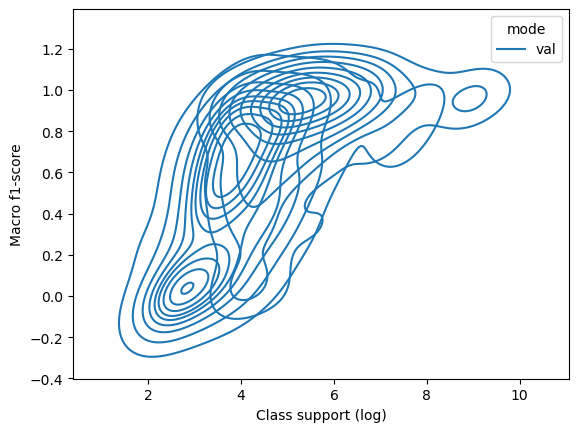

In [31]:
from src.utils.activations import ScaleByFactor

# Set logging directory
step_model_dir = os.path.join(model_dir, 'rl+kl+c+cl')
train_params['logger'] = pl.loggers.TensorBoardLogger(step_model_dir)
# Set parameters
plan_params['lr'] = 1e-3
plan_params['lr_patience'] = 30
plan_params['n_epochs_kl_warmup'] = 400               # KL should already be warmed up
plan_params['min_kl_weight'] = 0                      # Start KL at previous scvi max
plan_params['max_kl_weight'] = 1                      # Set max
plan_params['n_epochs_cls_warmup'] = 200              # Gradually increase classification loss
plan_params['n_epochs_cls_stall'] = 0
plan_params['min_cls_weight'] = 1e-9
plan_params['max_cls_weight'] = 1
plan_params['use_posterior_mean'] = 'val'
plan_params['n_epochs_contr_warmup'] = 120              # Gradually increase classification loss
plan_params['n_epochs_contr_stall'] = 0
plan_params['min_contr_weight'] = 0
plan_params['max_contr_weight'] = 1
plan_params['lr_scheduler_metric'] = 'validation_classification_loss'
gedvae_params['decode_g'] = True                     # Decode zg latent space and add a reconstruction loss an that
gedvae_params['emb_likelihood'] = 'normal'
gedvae_params['use_x_in_zg'] = False                     # Decode g together with x
gedvae_params['g_activation'] = ScaleByFactor(10)        # Scale embedding by factor to push values further from 0 (control)
gedvae_params['g_classification_weight'] = 0         # Classification loss (zxg)
gedvae_params['contrastive_loss_weight'] = 1       # Classification loss (zxg)
gedvae_params['contrastive_y'] = 0                    # Try different settings here (0=similar, 1=dissimilar)
gedvae_params['use_attention_encoder'] = False
gedvae_params['dropout_rate'] = 0.2
gedvae_params['dropout_rate_encoder_g'] = 0.1
gedvae_params['l1_lambda'] = 1e-4
train_params['plan_kwargs'] = plan_params          # Update plan params
train_params['early_stopping_monitor'] = 'validation_classification_loss'
train_params['early_stopping_patience'] = 12
train_params['early_stopping'] = True
train_params['max_epochs'] = 200
# Setup anndata with model
GEDVI.setup_anndata(
    model_set, batch_key=batch_key, labels_key=cls_label, unlabeled_category='unknown',
    categorical_covariate_keys=cat_covs
)
# Training parameters
gedvae = GEDVI(model_set, **gedvae_params.copy())
# Train the model
logging.info(f'Running at: {step_model_dir}')
gedvae.train(data_params=data_params.copy(), model_params=gedvae_params.copy(), train_params=train_params.copy(), return_runner=False)
# Save results to lightning directory
results, latent = get_model_results(
    model=gedvae, cls_labels=cls_labels, log_dir=step_model_dir, plot=True
)

#### Step 5: Switch KL for contrastive loss on pre-trained scvi

In [33]:
from scvi.model._scvi import SCVI

# Load pre-trained scvi model
scvi_model_dir = os.path.join(model_dir, 'scvi', str(n_labels))
scvi = SCVI.load(scvi_model_dir, adata=model_set)
scvi

INFO     File models/run1/scvi/3981/model.pt already downloaded                                                    


SCVI model with the following parameters: 
n_hidden: 256, n_latent: 128, n_layers: 1, dropout_rate: 0.2, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal.
Training status: Trained
Model's adata is minified?: False

In [ ]:
from src.utils.activations import ScaleByFactor

# Set logging directory
step_model_dir = os.path.join(model_dir, 'scvi+rl+kl+c+cl')
train_params['logger'] = pl.loggers.TensorBoardLogger(step_model_dir)
# Set parameters
plan_params['lr'] = 1e-4
plan_params['lr_patience'] = 30
plan_params['n_epochs_kl_warmup'] = 400               # KL should already be warmed up
plan_params['min_kl_weight'] = 0.1                      # Start KL at previous scvi max
plan_params['max_kl_weight'] = 1                      # Set max
plan_params['n_epochs_cls_warmup'] = 100              # Gradually increase classification loss
plan_params['n_epochs_cls_stall'] = 0
plan_params['min_cls_weight'] = 1e-9
plan_params['max_cls_weight'] = 1
plan_params['use_posterior_mean'] = 'both'
plan_params['n_epochs_contr_warmup'] = 120              # Gradually increase classification loss
plan_params['n_epochs_contr_stall'] = 40
plan_params['min_contr_weight'] = 0
plan_params['max_contr_weight'] = 0
plan_params['lr_scheduler_metric'] = 'validation_classification_loss'
gedvae_params['decode_g'] = False                     # Decode zg latent space and add a reconstruction loss an that
gedvae_params['emb_likelihood'] = 'normal'
gedvae_params['use_x_in_zg'] = False                     # Decode g together with x
gedvae_params['g_activation'] = ScaleByFactor(10)        # Scale embedding by factor to push values further from 0 (control)
gedvae_params['g_classification_weight'] = 0         # Classification loss (zxg)
gedvae_params['contrastive_loss_weight'] = 0       # Classification loss (zxg)
gedvae_params['contrastive_y'] = 0                    # Try different settings here (0=similar, 1=dissimilar)
gedvae_params['dropout_rate'] = 0.2
gedvae_params['dropout_rate_encoder_g'] = 0.1
gedvae_params['l1_lambda'] = 1e-4
train_params['plan_kwargs'] = plan_params          # Update plan params
train_params['early_stopping_monitor'] = 'validation_classification_loss'
train_params['early_stopping_patience'] = 5
train_params['early_stopping'] = True
train_params['max_epochs'] = 100
# Setup anndata with model
gedvae = GEDVI.from_scvi_model(
    scvi,
    labels_key=cls_label, unlabeled_category='unknown',
    **gedvae_params.copy()
)
# Train the model
logging.info(f'Running at: {step_model_dir}')
gedvae.train(data_params=data_params.copy(), model_params=gedvae_params.copy(), train_params=train_params.copy(), return_runner=False)
# Save results to lightning directory
results, latent = get_model_results(
    model=gedvae, cls_labels=cls_labels, log_dir=step_model_dir, plot=True
)

/tmp/ipykernel_2419562/1426434816.py:38: UserWarning: Ignoring param 'n_hidden' as it was already passed in to pretrained SCVI model with value 256.
  gedvae = GEDVI.from_scvi_model(
/tmp/ipykernel_2419562/1426434816.py:38: UserWarning: Ignoring param 'n_latent' as it was already passed in to pretrained SCVI model with value 128.
  gedvae = GEDVI.from_scvi_model(
/tmp/ipykernel_2419562/1426434816.py:38: UserWarning: Ignoring param 'n_layers' as it was already passed in to pretrained SCVI model with value 1.
  gedvae = GEDVI.from_scvi_model(
/tmp/ipykernel_2419562/1426434816.py:38: UserWarning: Ignoring param 'dropout_rate' as it was already passed in to pretrained SCVI model with value 0.2.
  gedvae = GEDVI.from_scvi_model(
/tmp/ipykernel_2419562/1426434816.py:38: UserWarning: Ignoring param 'dispersion' as it was already passed in to pretrained SCVI model with value gene.
  gedvae = GEDVI.from_scvi_model(
/tmp/ipykernel_2419562/1426434816.py:38: UserWarning: Ignoring param 'gene_likel

Training:   0%|          | 0/100 [00:00<?, ?it/s]

#### Step 6? Train with class embeddings

In [84]:
from src.models._jedvi import JEDVI

model_dir = 'models/contrastive_hp_grid'
# Set logging directory
step_model_dir = os.path.join(model_dir, 'rl+kl+ce')
train_params['logger'] = pl.loggers.TensorBoardLogger(step_model_dir)

data_params = {
    'train_size': 0.9,
    'batch_size': None,
    'num_workers': 1,
    # Contrastive splitter parameters, cpp * cbp = batch_size
    'max_cells_per_batch': 32,
    'max_classes_per_batch': 32,
    'last_first': False,
    'shuffle_classes': True,
    'use_contrastive_loader': None,
}
cls_params = {
    'n_hidden': 128, 'n_layers': 1, 'dropout_rate': 0.1,
    'use_multihead': False, 'use_cosine_similarity': True, 'temperature': 0.1
}
# Set model parameters
jedvae_params = {
    'n_hidden': 512,
    'n_latent': 256,
    'n_layers': 2,
    'dropout_rate': 0.2,
    'dispersion': 'gene',
    'use_batch_norm': 'both',
    'gene_likelihood': likelihood,
    'linear_classifier': False,
    'classifier_parameters': cls_params,
    'log_variational': likelihood == 'zinb',
    'use_attention_encoder': False,
    'l1_lambda': 0,
    'cls_weight_method': 'balanced',
    'use_focal_loss': True,
    'focal_gamma': 1.0,
    'reduction': 'mean'
}
# Set parameters
plan_params['lr'] = 1e-3
plan_params['lr_patience'] = 30
plan_params['n_epochs_kl_warmup'] = 600               # KL should already be warmed up
plan_params['min_kl_weight'] = 0                      # Start KL at previous scvi max
plan_params['max_kl_weight'] = 2                      # Set max
plan_params['n_epochs_contr_warmup'] = 600              # Gradually increase contrastive loss for classes
plan_params['n_epochs_contr_stall'] = 100
plan_params['min_contr_weight'] = 0
plan_params['max_contr_weight'] = 4
plan_params['contrastive_temperature'] = 0.05
plan_params['n_epochs_cls_warmup'] = 600              # Gradually increase classification loss
plan_params['n_epochs_cls_stall'] = 100                   # Start after contrastive loss is already established --> should be way easier to classify then
plan_params['min_cls_weight'] = 0
plan_params['max_cls_weight'] = 1
plan_params['n_epochs_align_warmup'] = 400              # Skip alignment score --> not compatible with cosine-based classifier
plan_params['n_epochs_align_stall'] = 0                    # 0
plan_params['min_align_weight'] = 0                                                 
plan_params['max_align_weight'] = 0
plan_params['use_posterior_mean'] = 'val'
plan_params['lr_scheduler_metric'] = 'elbo_validation'
plan_params['log_class_distribution'] = True
plan_params['plot_umap'] = True
train_params['plan_kwargs'] = plan_params          # Update plan params
train_params['early_stopping_monitor'] = 'elbo_validation'
train_params['early_stopping_patience'] = 30
train_params['check_val_every_n_epoch'] =  1
train_params['early_stopping'] = False
train_params['max_epochs'] = 600
# Setup anndata with model
JEDVI.setup_anndata(
    model_set, batch_key=batch_key, labels_key=cls_label, unlabeled_category='unknown',
    categorical_covariate_keys=['celltype']
)
# Training parameters
jedvae = JEDVI(model_set, **jedvae_params.copy())

2025-06-20 16:45:45,229 - INFO - Class embedding has already been initialized with <class 'src.models._jedvi.JEDVI'> for this adata.


In [ ]:
# Train the model
logging.info(f'Running at: {step_model_dir}')
runner = jedvae.train(data_params=data_params.copy(), model_params=jedvae_params.copy(), train_params=train_params.copy(), return_runner=True)
runner()

2025-06-20 16:45:48,744 - INFO - Running at: models/contrastive_hp_grid/rl+kl+ce
2025-06-20 16:45:48,745 - INFO - Epochs suggested: 146, training for 600 epochs.
INFO: GPU available: True (cuda), used: True
2025-06-20 16:45:48,914 - INFO - GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
2025-06-20 16:45:48,914 - INFO - TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
2025-06-20 16:45:48,914 - INFO - HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2025-06-20 16:45:48,954 - INFO - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: SLURM auto-requeueing enabled. Setting signal handlers.
2025-06-20 16:45:48,970 - INFO - SLURM auto-requeueing enabled. Setting signal handlers.
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasin

Training:   0%|          | 0/600 [00:00<?, ?it/s]

In [ ]:
# Save results to lightning directory
results, latent = get_model_results(
    model=jedvae, cls_labels=cls_labels, log_dir=step_model_dir, plot=True
)

In [ ]:
print(model_set.obs.groupby('celltype', observed=True).cls_label.value_counts())

### HP grid with Test different batch sizes with contrastive loss only

In [ ]:
def run_trial(dp: dict, keys: list[str] = ['batch_size']):
    # Set logging directory
    keys_str = "_".join([f"{k}:{dp.get(k)}" for k in keys if k in dp])
    step_model_dir = os.path.join(trial_dir, keys_str)
    train_params['logger'] = pl.loggers.TensorBoardLogger(step_model_dir)
 
    # Setup anndata with model
    JEDVI.setup_anndata(
        model_set, batch_key=batch_key, labels_key=cls_label, unlabeled_category='unknown',
        categorical_covariate_keys=['celltype']
    )
    # Training parameters
    jedvae = JEDVI(model_set, **jedvae_params.copy())
    # Train the model
    logging.info(f'Running at: {step_model_dir}')
    jedvae.train(data_params=dp.copy(), model_params=jedvae_params.copy(), train_params=train_params.copy(), return_runner=False)
    # Save results to lightning directory
    results, latent = get_model_results(
        model=jedvae, cls_labels=cls_labels, log_dir=step_model_dir, plot=True
    )
    return results

In [ ]:
import numpy as np
# Grid with fixed number of classes / batch
trial_dir = 'models/contrastive_hp_grid/max_cells_max_classes+c'
os.makedirs(trial_dir, exist_ok=True)
rs = []
# Define search space for max cells and max classes per batch
space = np.array([8, 16, 32, 64])

for ms in space:
    for mc in space:
        bs = int(ms*mc)
        logging.info(f"ms({ms})*mc({mc})={bs}")
        tmp_data_params = {
            'train_size': 0.9,
            'batch_size': bs,
            'num_workers': 1,
            # Contrastive splitter parameters, cpp * cbp should be batch_size
            'max_cells_per_batch': int(ms),
            'max_classes_per_batch': int(mc),
            'last_first': False,
            'shuffle_classes': True
        }
        r = run_trial(tmp_data_params, keys=['max_cells_per_batch', 'max_classes_per_batch'])
        r['batch_size'] = bs
        r['max_cells_per_batch'] = ms
        r['max_classes_per_batch'] = mc
        rs.append(r)
rs = pd.concat(rs, axis=0)

In [ ]:
# --> ms 32, mc 16

### Pre-train + Cosine similarity on embedding

In [46]:
from src.models._jedvi import JEDVI

# Set logging directory
step_model_dir = os.path.join(model_dir, 'rl+kl+ce')
train_params['logger'] = pl.loggers.TensorBoardLogger(step_model_dir)

cls_params = {
    'n_hidden': 128, 'n_layers': 1, 'dropout_rate': 0.1,
    'use_multihead': False, 'use_cosine_similarity': True, 'temperature': 0.05
}
# Set model parameters
jedvae_params = {
    'n_hidden': 256,
    'n_latent': 128,
    'n_layers': 1,
    'dropout_rate': 0.2,
    'dispersion': 'gene',
    'use_batch_norm': 'both',
    'gene_likelihood': likelihood,
    'linear_classifier': False,
    'classifier_parameters': cls_params,
    'log_variational': likelihood == 'zinb',
    'use_attention_encoder': False,
    'l1_lambda': 0,
    'cls_weight_method': None,
    'use_focal_loss': False,
    'focal_gamma': 1.0,
}
# Set parameters
plan_params['lr'] = 1e-3
plan_params['lr_patience'] = 30
plan_params['n_epochs_kl_warmup'] = 400               # KL should already be warmed up
plan_params['min_kl_weight'] = 1                      # Start KL at previous scvi max
plan_params['max_kl_weight'] = 1                      # Set max
plan_params['n_epochs_cls_warmup'] = 400              # Gradually increase classification loss
plan_params['n_epochs_cls_stall'] = 0                   # Start at beginning
plan_params['min_cls_weight'] = 1e-9
plan_params['max_cls_weight'] = 1
plan_params['n_epochs_align_warmup'] = 400              # Skip alignment score --> not compatible with cosine-based classifier
plan_params['n_epochs_align_stall'] = 0                    # 0
plan_params['min_align_weight'] = 0                                                 
plan_params['max_align_weight'] = 0
plan_params['use_posterior_mean'] = 'val'
plan_params['lr_scheduler_metric'] = 'elbo_validation'
train_params['plan_kwargs'] = plan_params          # Update plan params
train_params['early_stopping_monitor'] = 'elbo_validation'
train_params['early_stopping_patience'] = 10
train_params['early_stopping'] = True
train_params['max_epochs'] = 120
# Setup anndata with model
JEDVI.from_scvi_model(
    scvi, labels_key=cls_label, unlabeled_category='unknown'
)
# Training parameters
jedvae = JEDVI(model_set, **jedvae_params.copy())

2025-05-30 09:32:23,058 - INFO - Class embedding has already been initialized with <class 'src.models._jedvi.JEDVI'> for this adata.
2025-05-30 09:32:23,232 - INFO - Class embedding has already been initialized with <class 'src.models._jedvi.JEDVI'> for this adata.


In [47]:
# Train the model
logging.info(f'Running at: {step_model_dir}')
jedvae.train(data_params=data_params.copy(), model_params=jedvae_params.copy(), train_params=train_params.copy(), return_runner=False)

2025-05-30 09:32:35,693 - INFO - Running at: models/disentangle_losses/rl+kl+ce
2025-05-30 09:32:35,694 - INFO - Epochs suggested: 144, training for 120 epochs.
INFO: GPU available: True (cuda), used: True
2025-05-30 09:32:36,097 - INFO - GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
2025-05-30 09:32:36,097 - INFO - TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
2025-05-30 09:32:36,098 - INFO - HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2025-05-30 09:32:36,104 - INFO - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/pytorch_lightning/core/saving.py:363: Skipping 'train_params' parameter because it is not possible to safely dump to YAML.
INFO: SLURM auto-requeueing enabled. Setting signal handlers.
2025-05-30 09:32:36,120 - INFO - SLURM auto-requeueing enabled. Setting signal handlers.
/home/xlv0877/.conda/envs/pydl/li

Training:   0%|          | 0/120 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 10 records. Best score: 8593.324. Signaling Trainer to stop.


2025-05-30 09:46:24,839 - INFO - Processing train set
2025-05-30 09:46:28,559 - INFO - Calculating latent neighbors
2025-05-30 09:46:32,175 - INFO - Calculating latent umap
2025-05-30 09:46:56,076 - INFO - Plotting train for label: perturbation_direction
... storing 'cls_prediction' as categorical
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
2025-05-30 09:46:57,302 - INFO - Plotting train for label: perturbation
2025-05-30 09:46:59,341 - INFO - Plotting train for label: dataset
2025-05-30 09:47:01,052 - INFO - Processing val set
2025-05-30 09:47:02,012 - INFO - Calculating latent neighbors
2025-05-30 09:47:03,602 - INFO - Calculating latent umap
2025-05-30 09:47:09,525 - INFO - Plotting val for label: perturbation_direction
... storing 'cls_predicti

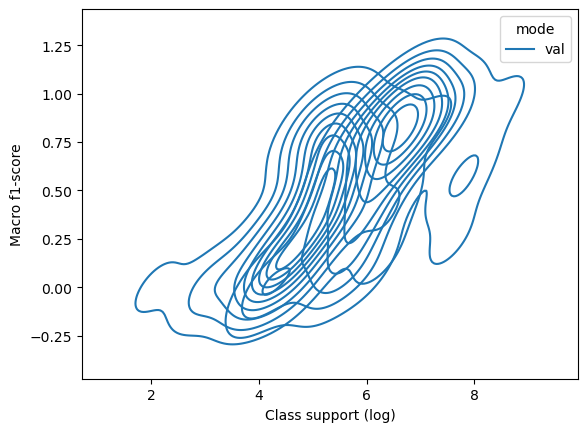

In [48]:
# Save results to lightning directory
results, latent = get_model_results(
    model=jedvae, cls_labels=cls_labels, log_dir=step_model_dir, plot=True
)

### Train with attention layer

In [38]:
from src.utils.activations import ScaleByFactor

# Set logging directory
step_model_dir = os.path.join(model_dir, 'rl+kl+c+a')
train_params['logger'] = pl.loggers.TensorBoardLogger(step_model_dir)
# Set parameters
plan_params['lr'] = 1e-3
plan_params['lr_patience'] = 30
plan_params['n_epochs_kl_warmup'] = 400               # KL should already be warmed up
plan_params['min_kl_weight'] = 0                      # Start KL at previous scvi max
plan_params['max_kl_weight'] = 1                      # Set max
plan_params['n_epochs_cls_warmup'] = 200              # Gradually increase classification loss
plan_params['n_epochs_cls_stall'] = 0
plan_params['min_cls_weight'] = 1e-9
plan_params['max_cls_weight'] = 1
plan_params['use_posterior_mean'] = 'val'
plan_params['n_epochs_contr_warmup'] = 120              # Gradually increase classification loss
plan_params['n_epochs_contr_stall'] = 40
plan_params['min_contr_weight'] = 0
plan_params['max_contr_weight'] = 0
plan_params['lr_scheduler_metric'] = 'validation_classification_loss'
gedvae_params['decode_g'] = False                     # Decode zg latent space and add a reconstruction loss an that
gedvae_params['emb_likelihood'] = 'normal'
gedvae_params['use_x_in_zg'] = False                     # Decode g together with x
gedvae_params['g_activation'] = ScaleByFactor(10)        # Scale embedding by factor to push values further from 0 (control)
gedvae_params['g_classification_weight'] = 0         # Classification loss (zxg)
gedvae_params['contrastive_loss_weight'] = 0       # Classification loss (zxg)
gedvae_params['contrastive_y'] = 0                    # Try different settings here (0=similar, 1=dissimilar)
gedvae_params['use_attention_encoder'] = True
gedvae_params['dropout_rate'] = 0.2
gedvae_params['dropout_rate_encoder_g'] = 0.1
gedvae_params['l1_lambda'] = 1e-4
train_params['plan_kwargs'] = plan_params          # Update plan params
train_params['early_stopping_monitor'] = 'validation_classification_loss'
train_params['early_stopping_patience'] = 12
train_params['early_stopping'] = True
train_params['max_epochs'] = 200
# Setup anndata with model
GEDVI.setup_anndata(
    model_set, batch_key=batch_key, labels_key=cls_label, unlabeled_category='unknown',
    categorical_covariate_keys=cat_covs, gene_emb_obsm_key=None
)
# Training parameters
gedvae = GEDVI(model_set, **gedvae_params.copy())
# Train the model
logging.info(f'Running at: {step_model_dir}')
gedvae.train(data_params=data_params.copy(), model_params=gedvae_params.copy(), train_params=train_params.copy(), return_runner=False)
# Save results to lightning directory
results, latent = get_model_results(
    model=gedvae, cls_labels=cls_labels, log_dir=step_model_dir, plot=True
)

/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
2025-05-26 22:57:40,658 - INFO - Running at: models/disentangle_losses/rl+kl+c+a
2025-05-26 22:57:40,658 - INFO - Epochs suggested: 54, training for 200 epochs.
INFO: GPU available: True (cuda), used: True
2025-05-26 22:57:40,852 - INFO - GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
2025-05-26 22:57:40,854 - INFO - TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
2025-05-26 22:57:40,855 - INFO - HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2025-05-26 22:57:40,863 - INFO - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/pytorch_lightning/core/saving.py:363: Skipping 'train_params' parameter because it is not possible to s

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Monitored metric validation_classification_loss did not improve in the last 12 records. Best score: 112.102. Signaling Trainer to stop.


TypeError: get_model_results() got an unexpected keyword argument 'ignore_embedding'

### Plot performance over cell types

In [30]:
# Check performance per cell and perturbation type
import matplotlib.pyplot as plt
import seaborn as sns
from src.plotting import get_latest_tensor_dir

version_dir = get_latest_tensor_dir(step_model_dir)
plt_dir = os.path.join(version_dir, 'plots')
cond_p = os.path.join(plt_dir, 'validation_f1_conditions.png')
pal = []
val_results = results[results['mode']=='val'].copy()
val_results['cond'] = val_results['celltype'].astype(str) + ', ' + val_results['perturbation_type'].astype(str)
val_results['cond'] = pd.Categorical(val_results['cond'], categories=val_results.groupby('cond')['f1-score'].mean().sort_values().index, ordered=True)
val_results['pt'] = pd.Categorical(
    val_results['perturbation_type'],
    categories=['CRISPR-cas9', 'CRISPR-cas9, TCR stim', 'CRISPRa', 'CRISPRi'], 
    ordered=True
)
plt.figure(dpi=300)
ax = sns.boxplot(val_results, x='celltype', y='f1-score', hue='pt')
#plt.xticks(rotation=45, ha='right')
ax.legend(title='perturbation type',
          loc='upper center',          # center it horizontally
          bbox_to_anchor=(0.5, -0.15), # move it below the axes
          ncol=2,                      # arrange legend in two columns (optional)
          fontsize=10,                 # adjust font size
          title_fontsize=11)

plt.tight_layout()
#plt.savefig(cond_p, dpi=300, bbox_inches='tight')
plt.show()

KeyError: 'celltype'

### Plot OvA ROC-curve and PR-curve

#### ROC

In [57]:
from sklearn.preprocessing import label_binarize

val_set = model_set[gedvae.validation_indices]
y = val_set.obs._scvi_labels.values
labels = val_set.obs.cls_label.values
y_score = gedvae.predict(indices=gedvae.validation_indices, ignore_embedding=True, soft=True).values

classes = np.unique(y)
y_test_bin = label_binarize(y, classes=classes)
n_classes = y_test_bin.shape[1]

In [61]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [67]:
fpr["micro"], tpr["micro"], _ = roc_curve(
    y_test_bin.ravel(),        # flatten all true binary labels
    y_score.ravel()            # flatten all predicted scores
)
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [68]:
# aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# then interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# average it and compute AUC
mean_tpr /= n_classes
fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

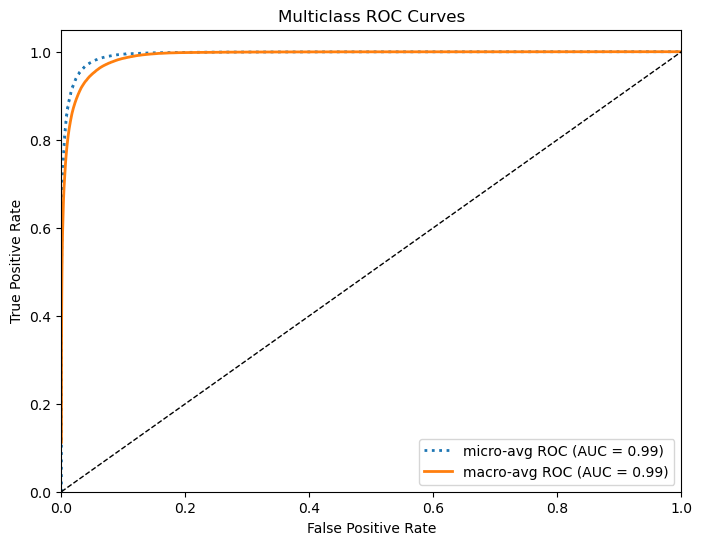

In [78]:
plt.figure(figsize=(8, 6))

# micro & macro
plt.plot(
    fpr["micro"], tpr["micro"],
    linestyle=':', linewidth=2,
    label=f'micro-avg ROC (AUC = {roc_auc["micro"]:.2f})'
)
plt.plot(
    fpr["macro"], tpr["macro"],
    linestyle='-', linewidth=2,
    label=f'macro-avg ROC (AUC = {roc_auc["macro"]:.2f})'
)

# diagonal and labels
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim(0.0, 1.0); plt.ylim(0.0, 1.05)
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curves')
plt.legend(loc='lower right')
plt.show()

#### PR-curve

In [73]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from tqdm import tqdm


# 2. Compute per-class PR curve and AP (average precision = PR-AUC)
precision = dict()
recall = dict()
ap = dict()
for i in tqdm(range(n_classes)):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    ap[i] = average_precision_score(y_test_bin[:, i], y_score[:, i])

# 3. Compute micro-average PR curve and AP
precision_micro, recall_micro, _ = precision_recall_curve(
    y_test_bin.ravel(), y_score.ravel()
)
ap["micro"] = average_precision_score(y_test_bin, y_score, average="micro")

# 4. Compute macro-average AP directly
ap["macro"] = average_precision_score(y_test_bin, y_score, average="macro")

KeyboardInterrupt: 

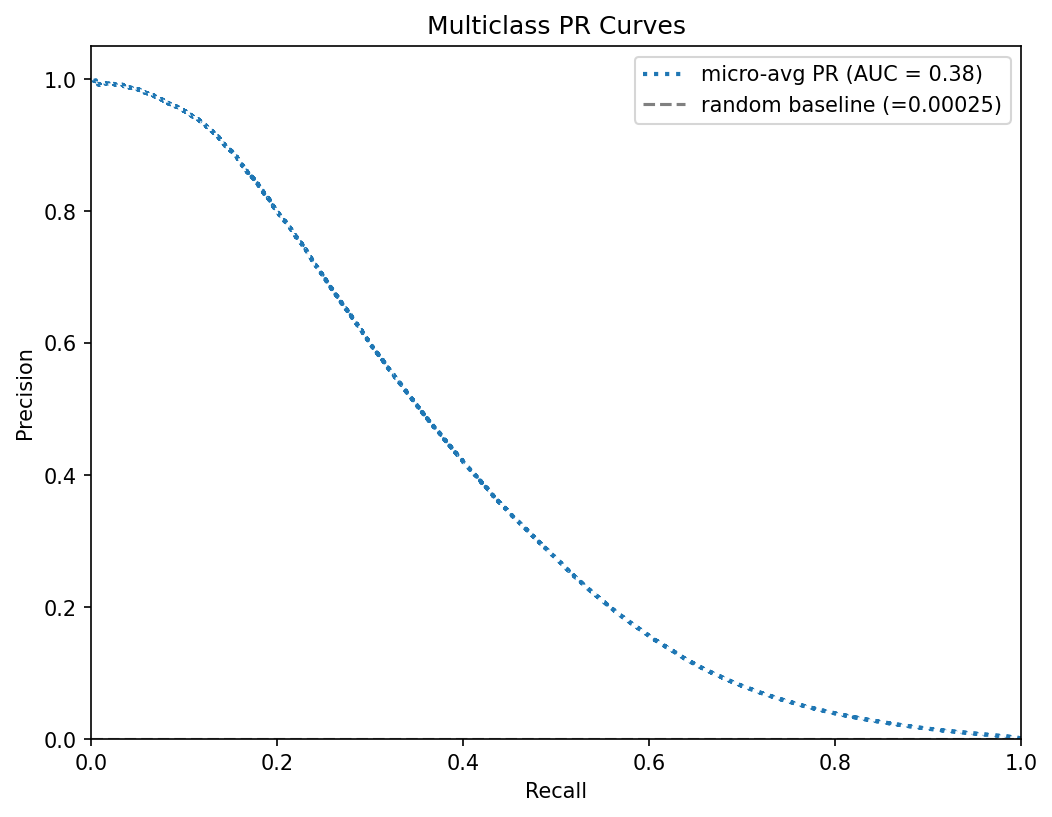

In [101]:
plt.figure(figsize=(8, 6), dpi=150)

# micro & macro
plt.plot(
    recall_micro, precision_micro,
    linestyle=':', linewidth=2,
    label=f'micro-avg PR (AUC = {ap["micro"]:.2f})'
)
# Compute baseline (fraction of positives)
baseline = y_test_bin.sum() / y_test_bin.size
plt.hlines(baseline, 0, 1, linestyle='--', color='gray', label=f'random baseline (={baseline:.5f})')

plt.xlim(0.0, 1.0); plt.ylim(0.0, 1.05)
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.title('Multiclass PR Curves')
plt.legend(loc='best')
plt.show()

In [76]:
print("Average precision (PR-AUC) scores:")
print(f"  micro-avg = {ap['micro']:.3f}")
print(f"  macro-avg = {ap['macro']:.3f}")
for i in range(n_classes):
    print(f"  class {classes[i]:>2} = {ap[i]:.3f}")

Average precision (PR-AUC) scores:
  micro-avg = 0.384
  macro-avg = 0.270
  class  0 = 0.055
  class  1 = 0.030
  class  2 = 0.040
  class  3 = 0.018
  class  4 = 0.068
  class  5 = 0.008
  class  6 = 0.038
  class  7 = 0.024
  class  8 = 0.022
  class  9 = 0.026
  class 10 = 0.033
  class 11 = 0.046
  class 12 = 0.117
  class 13 = 0.114
  class 14 = 0.060
  class 15 = 0.167
  class 16 = 0.020
  class 17 = 0.169
  class 18 = 0.037
  class 19 = 0.014
  class 20 = 0.051
  class 21 = 0.010
  class 22 = 0.049
  class 23 = 0.047
  class 24 = 0.019
  class 25 = 0.124
  class 26 = 0.111
  class 27 = 0.050
  class 28 = 0.151
  class 29 = 0.716
  class 30 = 0.030
  class 31 = 0.194
  class 32 = 0.376
  class 33 = 0.196
  class 34 = 0.156
  class 35 = 0.019
  class 36 = 0.213
  class 37 = 0.122
  class 38 = 0.844
  class 39 = 0.014
  class 40 = 0.231
  class 41 = 0.248
  class 42 = 0.149
  class 43 = 0.020
  class 44 = 0.008
  class 45 = 0.010
  class 46 = 0.041
  class 47 = 0.567
  class 48 = 

### Plot f1 score for top predictions TODO: move this to model plotter

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
from src.plotting import get_latest_tensor_dir
from tqdm import tqdm


model = jedvae
val_set = model_set[model.validation_indices].copy()
val_set.obs['idx'] = model.validation_indices
val_set = val_set[val_set.obs.perturbation!='control']
soft_predictions = model.predict(indices=val_set.obs['idx'].values, soft=True)
# Plot wo ctrl
y = val_set.obs._scvi_labels.values
labels = val_set.obs.cls_label.values
# Look at top N predictions (can be useful for pathways etc.)
top_n_predictions = []
for top_n in tqdm(np.arange(1, 11)):
    top_predictions = np.argsort(soft_predictions, axis=1)[:,-top_n:]
    hit_mask = top_predictions == np.array(y)[:, np.newaxis]
    hit_idx = np.argmax(hit_mask, axis=1)
    is_hit = np.any(hit_mask, axis=1).astype(int)
    # Default to actual prediction if label is not in top n predictions
    stats_per_label = pd.DataFrame(
        {
            'y': np.concatenate([y[is_hit==1], y[is_hit==0]]),
            'idx': np.concatenate([(top_n+1-hit_idx[is_hit==1])/(top_n+1), np.repeat(0, np.sum(is_hit==0))]),
            'label': np.concatenate([labels[is_hit==1], labels[is_hit==0]]),
            'prediction': np.concatenate([y[is_hit==1], top_predictions[is_hit==0][:,-1]])
        }
    )
    # Calculate metrics for new predictions
    precision, recall, f1, support = precision_recall_fscore_support(stats_per_label.y, stats_per_label.prediction, average=None)
    
    # Add to dataframe
    metrics = pd.DataFrame(
        {
            'y': stats_per_label.y.unique(), 'cls_label': stats_per_label.label.unique(),
            'precision': precision, 'recall': recall, 'f1': f1, 'support': support, 'top_n': top_n
        }
    )
    metrics = metrics.merge(stats_per_label.groupby('y')['idx'].mean(), left_on='y', right_index=True)
    top_n_predictions.append(metrics)
top_n_predictions = pd.concat(top_n_predictions, axis=0)

In [ ]:
# Save figure to plt_dir
version_dir = get_latest_tensor_dir(step_model_dir)
plt_dir = os.path.join(version_dir, 'plots')
f1_p = os.path.join(plt_dir, 'validation_f1_top_n_predictions_wo_ctrl.png')

plt.figure(dpi=300)
top_n_predictions_no_ctrl = top_n_predictions[~top_n_predictions.cls_label.str.endswith('control')]
ax = sns.boxplot(top_n_predictions_no_ctrl, x='top_n', y='f1', hue='top_n', legend=False)
# Display means on top of boxes
means = top_n_predictions_no_ctrl.groupby('top_n')['f1'].mean()
for i, top_n_value in enumerate(sorted(top_n_predictions['top_n'].unique())):
    ax.text(i, 1.0, f'{means[top_n_value]:.2f}', 
            horizontalalignment='center', verticalalignment='bottom', fontsize=10)
plt.xlabel('Number of top predictions')
plt.ylabel('F1-score')
plt.title(f'Validation F1-score distribution over top predictions (N={n_labels})')
plt.savefig(f1_p, dpi=300, bbox_inches='tight')

#### PR curves for different number of predictions

In [37]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from tqdm import tqdm

plt.figure(figsize=(8, 6), dpi=150)
for top_n in tqdm(top_n_predictions.top_n.unique()):
    top_predictions = np.argsort(soft_predictions, axis=1)[:,-top_n:]
    hit_mask = top_predictions == np.array(y)[:, np.newaxis]
    hit_idx = np.argmax(hit_mask, axis=1)
    is_hit = np.any(hit_mask, axis=1).astype(int)
    # Default to actual prediction if label is not in top n predictions
    stats_per_label = pd.DataFrame(
        {
            'y': np.concatenate([y[is_hit==1], y[is_hit==0]]),
            'idx': np.concatenate([hit_idx[is_hit==1], np.repeat(-1, np.sum(is_hit==0))]),
            'label': np.concatenate([labels[is_hit==1], labels[is_hit==0]]),
            'prediction': np.concatenate([y[is_hit==1], top_predictions[is_hit==0][:,-1]])
        }
    )
    classes = np.unique(stats_per_label.y)
    y_test_bin = label_binarize(stats_per_label.y, classes=classes)
    n_classes = y_test_bin.shape[1]
    precision = dict()
    recall = dict()
    ap = dict()
    precision_micro, recall_micro, _ = precision_recall_curve(
        y_test_bin.ravel(), y_score.ravel()
    )
    ap["micro"] = average_precision_score(y_test_bin, y_score, average="micro")
    ap["macro"] = average_precision_score(y_test_bin, y_score, average="macro")
    # micro & macro
    plt.plot(
        recall_micro, precision_micro,
        linestyle=':', linewidth=2,
        label=f'top {top_n}: micro-avg PR (AUC = {ap["micro"]:.2f})'
    )

# Compute baseline (fraction of positives)
baseline = y_test_bin.sum() / y_test_bin.size
plt.hlines(baseline, 0, 1, linestyle='--', color='gray', label=f'random baseline (={baseline:.5f})')

plt.xlim(0.0, 1.0); plt.ylim(0.0, 1.05)
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.title('Multiclass PR Curves')
plt.legend(loc='best')
plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]


NameError: name 'y_score' is not defined

<Figure size 1200x900 with 0 Axes>

### Plot difference in latent spaces between training and testing

In [157]:
sc.pp.neighbors(latent, use_rep='X')
sc.tl.umap(latent)

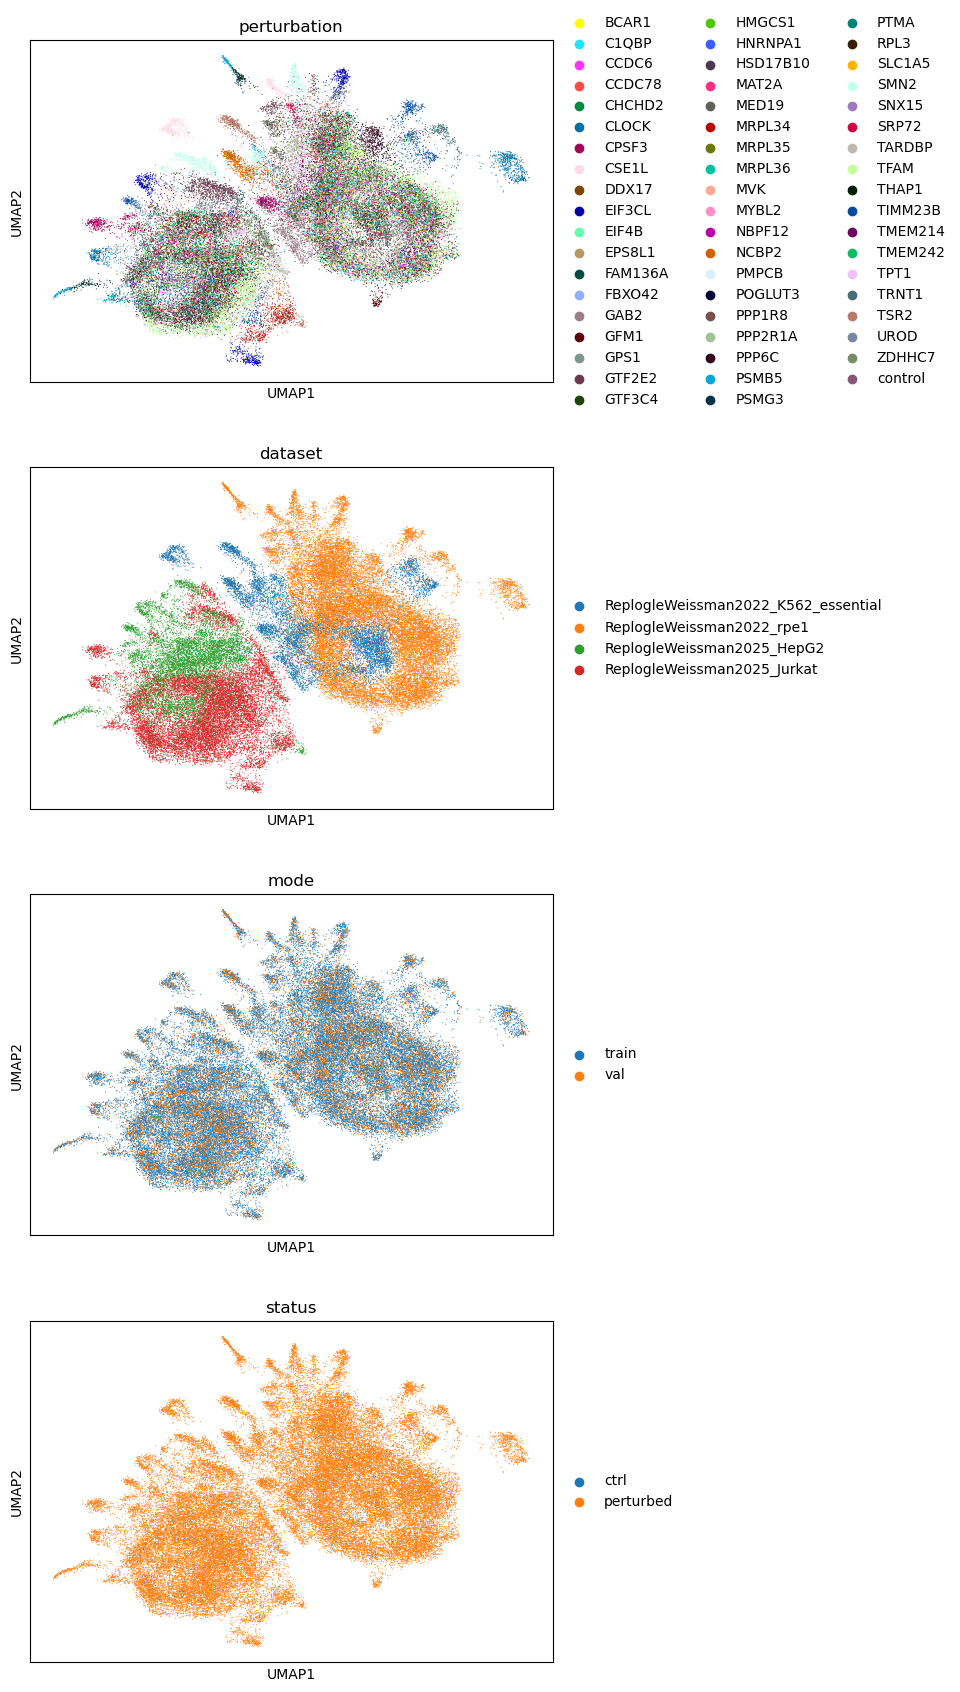

In [158]:
sc.pl.umap(latent, color=['perturbation', 'dataset', 'mode', 'status'], ncols=1)

### Test on unseen perturbations

In [71]:
unseen_adata.obs['actual_perturbation'] = unseen_adata.obs['perturbation'].values
unseen_adata.obs['perturbation'] = 'unknown'
logging.info('Running model with novel test data.')
version_dir = get_latest_tensor_dir(step_model_dir)
plt_dir = os.path.join(version_dir, 'plots')
predict_novel(gedvae, unseen_adata, 'perturbation', out_dir=version_dir, batch_key='dataset', emb_key=None)
plot_model_results_mode(test_adata, mode='test', batch_key='dataset', cls_labels=['perturbation'], plt_dir=plt_dir, add_key='unseen_perturbations')

2025-05-23 12:52:02,170 - INFO - Running model with novel test data.
2025-05-23 12:52:02,174 - INFO - Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
... storing 'perturbation' as categorical
... storing 'cls_label' as categorical
... storing 'status' as categorical
... storing 'scanvi_predictions' as categorical
2025-05-23 12:52:10,096 - INFO - Plotting test for label: perturbation
2025-05-23 12:52:11,944 - INFO - Plotting test for label: dataset
/projects/b1042/GoyalLab/lschwartz/dl/src/plotting.py:40: RuntimeWarning: invalid value encountered in divide
  cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nan

/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
... storing 'perturbation' as categorical
... storing 'mode' as categorical
... storing 'actual_perturbation' as categorical


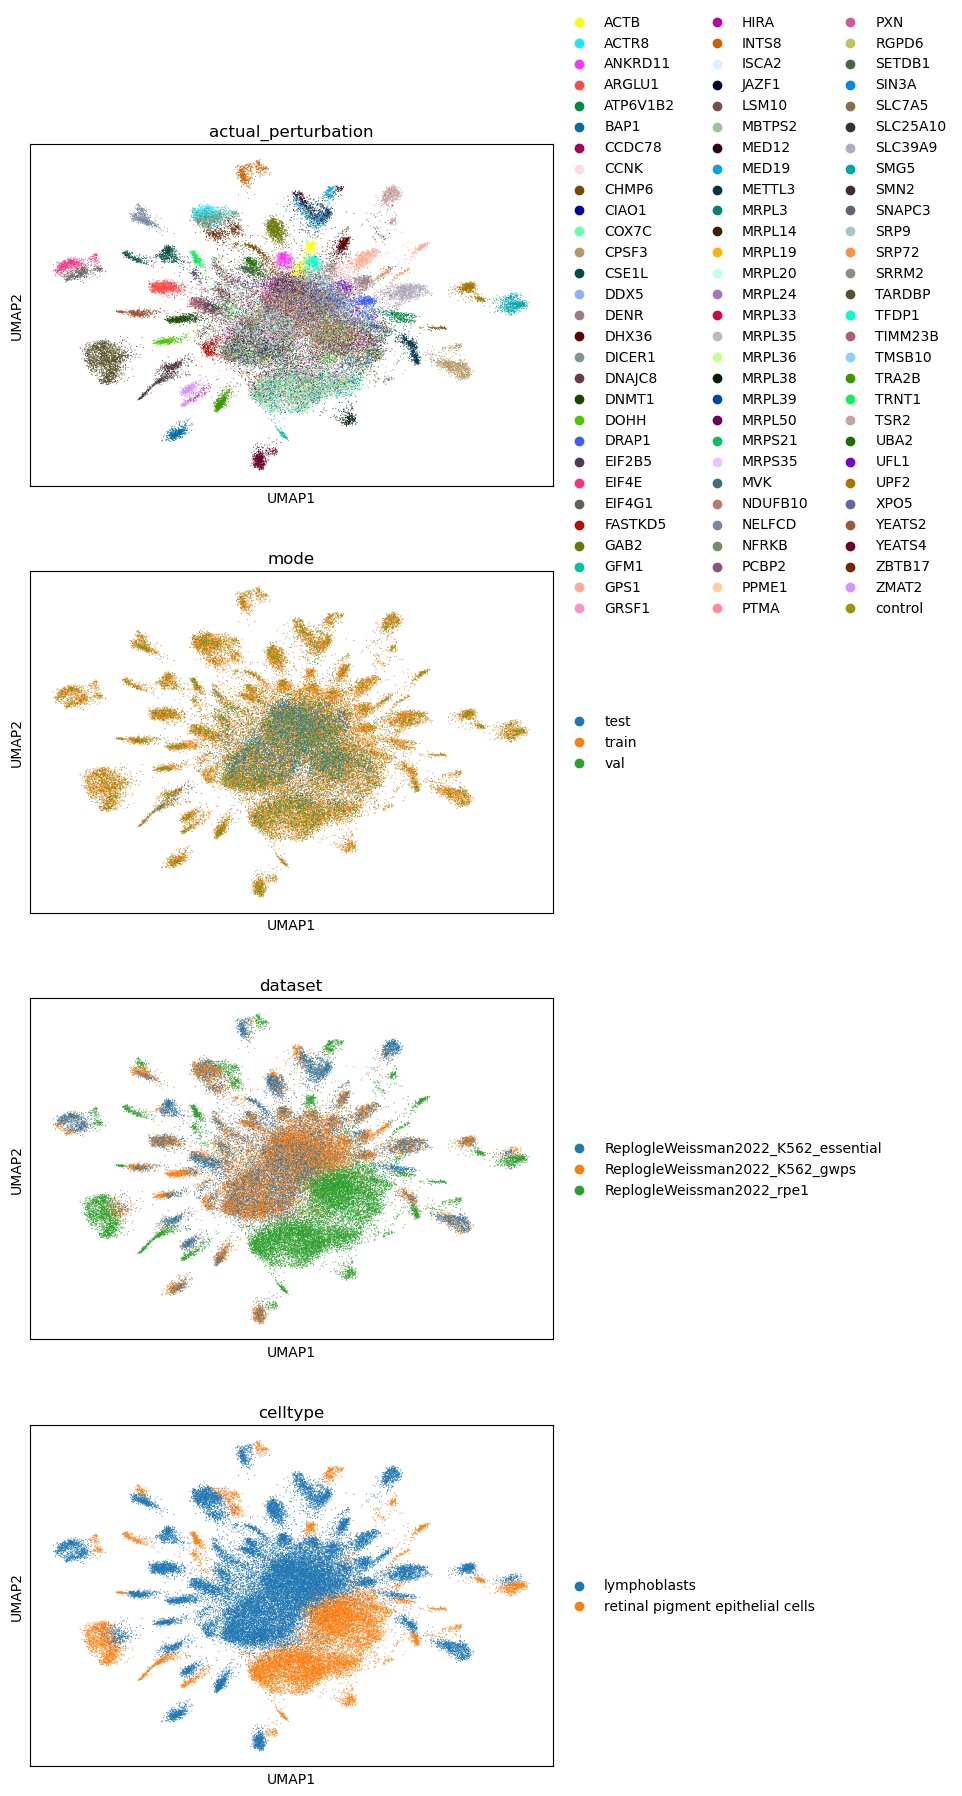

In [73]:
import anndata as ad

all_z = np.concatenate([latent.X, unseen_adata.obsm['latent_z']], axis=0)
obs_l = latent.obs.reset_index()[[*cls_labels, 'dataset', 'mode']]
obs_l['actual_perturbation'] = obs_l['perturbation'].values
obs_t = unseen_adata.obs.reset_index()[[*cls_labels, 'dataset', 'actual_perturbation']]
obs_t['mode'] = 'test'
all_latent = ad.AnnData(all_z, obs=pd.concat([obs_l, obs_t], axis=0, ignore_index=True))

# Check where in trained latent space test data is projected to
sc.pp.neighbors(all_latent, use_rep='X')
sc.tl.umap(all_latent)
sc.pl.umap(all_latent, color=['actual_perturbation', 'mode', 'dataset', 'celltype'], ncols=1)

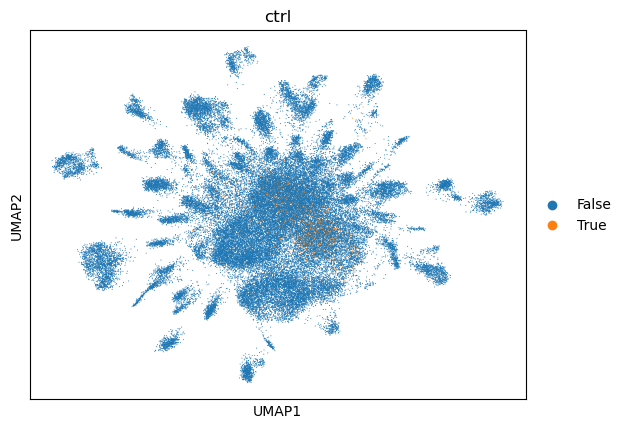

In [75]:
all_latent.obs['ctrl'] = False
all_latent.obs.loc[all_latent.obs['perturbation']=='control','ctrl'] = True
sc.pl.umap(all_latent, color='ctrl')

### Test on unseen celltype

In [36]:
test_p = '/home/xlv0877/proj_home/ExPert/resources/datasets/data/processed/ReplogleWeissman2025_HepG2.h5ad'
test_adata = sc.read(test_p)

In [37]:
# Subset adata to perturbations in trained model
model_perturbations = model_set.obs[cls_labels[-1]].unique()
p_mask = test_adata.obs[cls_labels[-1]].isin(model_perturbations)
test_adata._inplace_subset_obs(p_mask)
logging.info(f'Found {test_adata.obs[cls_labels[-1]].nunique()} perturbation(s) in model.')

2025-05-23 11:43:24,991 - INFO - Found 77 perturbation(s) in model.


In [38]:
# Subset genes to number of genes in model
model_genes = model_set.var.index
v_mask = test_adata.var.index.isin(model_genes)
test_adata._inplace_subset_var(v_mask)

/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [39]:
import anndata as ad
import scipy.sparse as sp
import numpy as np

missing_genes = model_genes.difference(test_adata.var.index)
missing_var = model_set[:,missing_genes].var
missing_obs = test_adata.obs.copy()
missing_X = np.zeros((test_adata.shape[0], missing_genes.shape[0]))
missing_X = sp.csr_matrix(missing_X)

missing_adata = ad.AnnData(X=missing_X, obs=missing_obs, var=missing_var)
test_adata = ad.concat([test_adata, missing_adata], axis=1)
test_adata.obs = missing_obs
test_adata

AnnData object with n_obs × n_vars = 13899 × 7079
    obs: 'gem_group', 'gene', 'gene_id', 'transcript', 'gene_transcript', 'sgID_AB', 'mitopercent', 'UMI_count', 'z_gemgroup_UMI', 'perturbation'

In [40]:
test_adata.obs[cls_labels[-1]].value_counts()

perturbation
control    4976
GFM1        749
SMN2        452
MRPL36      430
GAB2        355
           ... 
MRPL19       29
YEATS4       27
NDUFB10      27
MRPL33       18
MED12        14
Name: count, Length: 77, dtype: int64

In [52]:
from src.plotting import predict_novel, plot_model_results_mode, get_latest_tensor_dir
# Predict novel
ds_name = os.path.basename(test_p).split('.')[0]
test_adata.obs['dataset'] = ds_name
test_adata.obs['perturbation_type'] = 'CRISPRi'
test_adata.obs['celltype'] = 'lymphoblasts'
test_adata._inplace_subset_obs(test_adata.obs['perturbation'] != 'control')
test_adata.obs['cls_label'] = test_adata.obs[cls_labels].agg(';'.join, axis=1)
test_adata.obsm['gene_embedding'] = np.zeros((test_adata.shape[0], model_set.obsm['gene_embedding'].shape[1]))
logging.info('Running model with novel test data.')
version_dir = get_latest_tensor_dir(step_model_dir)
plt_dir = os.path.join(version_dir, 'plots')
predict_novel(gedvae, test_adata, 'perturbation', out_dir=version_dir, batch_key='dataset', emb_key=None)
plot_model_results_mode(test_adata, mode='test', batch_key='dataset', cls_labels=['perturbation'], plt_dir=plt_dir, add_key=ds_name)

2025-05-23 12:22:43,981 - INFO - Running model with novel test data.
... storing 'dataset' as categorical
... storing 'perturbation_type' as categorical
... storing 'celltype' as categorical
... storing 'cls_label' as categorical
... storing 'scanvi_predictions' as categorical
2025-05-23 12:23:16,972 - INFO - Plotting test for label: perturbation
2025-05-23 12:23:18,822 - INFO - Plotting test for label: dataset
/projects/b1042/GoyalLab/lschwartz/dl/src/plotting.py:40: RuntimeWarning: invalid value encountered in divide
  cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


In [62]:
test_adata

AnnData object with n_obs × n_vars = 8923 × 7079
    obs: 'gem_group', 'gene', 'gene_id', 'transcript', 'gene_transcript', 'sgID_AB', 'mitopercent', 'UMI_count', 'z_gemgroup_UMI', 'perturbation', 'dataset', 'perturbation_type', 'celltype', 'cls_label', '_scvi_batch', '_scvi_labels', 'scanvi_predictions'
    uns: '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap', 'report', 'celltype_colors', 'perturbation_type_colors', 'perturbation_colors', 'dataset_colors'
    obsm: 'gene_embedding', 'scanvi_z', 'X_umap'
    obsp: 'distances', 'connectivities'

In [64]:
import anndata as ad

all_z = np.concatenate([latent.X, test_adata.obsm['scanvi_z']], axis=0)
obs_l = latent.obs.reset_index()[[*cls_labels, 'dataset']]
obs_t = test_adata.obs.reset_index()[[*cls_labels, 'dataset']]
obs_t['mode'] = 'test'
all_latent = ad.AnnData(all_z, obs=pd.concat([obs_l, obs_t], axis=0, ignore_index=True))

# Check where in trained latent space test data is projected to
sc.pp.neighbors(all_latent, use_rep='X')
sc.tl.umap(all_latent)
sc.pl.umap(all_latent, color=['perturbation', 'dataset', 'celltype'], ncols=1)

/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 62736 × 128
    obs: 'celltype', 'perturbation_type', 'perturbation', 'dataset'

... storing 'celltype' as categorical
... storing 'perturbation' as categorical
... storing 'dataset' as categorical


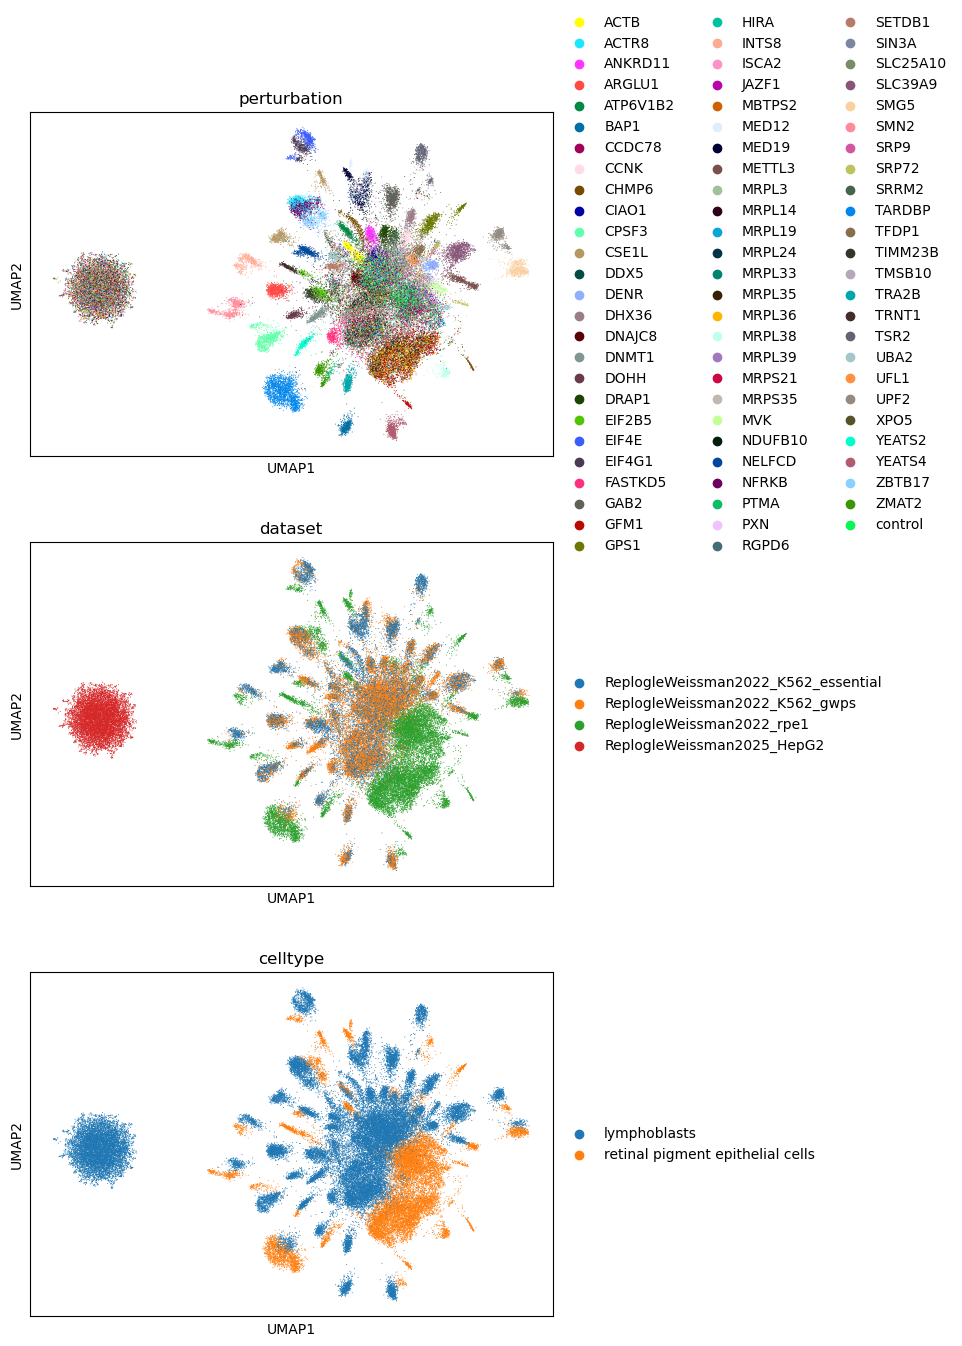

In [35]:
per_class_predictions = gedvae.predict(adata=test_adata, ignore_embedding=True, soft=True)

In [51]:
group_data = test_adata.obs.groupby(cls_label, observed=True)

In [61]:
classes, counts = np.unique(pred.ravel(), return_counts=True)

In [65]:
per_class_predictions.columns[classes[np.argsort(counts)]]

Index(['lymphoblasts;CRISPRi;DDX5', 'lymphoblasts;CRISPRi;METTL3',
       'lymphoblasts;CRISPRi;ISCA2', 'lymphoblasts;CRISPRi;ACTR8',
       'retinal pigment epithelial cells;CRISPRi;MRPL3',
       'retinal pigment epithelial cells;CRISPRi;TIMM23B',
       'lymphoblasts;CRISPRi;ARGLU1', 'lymphoblasts;CRISPRi;YEATS2',
       'lymphoblasts;CRISPRi;NELFCD', 'lymphoblasts;CRISPRi;MRPS6',
       'lymphoblasts;CRISPRi;ZBTB17', 'lymphoblasts;CRISPRi;INTS8',
       'lymphoblasts;CRISPRi;TRA2B', 'lymphoblasts;CRISPRi;C7orf26',
       'lymphoblasts;CRISPRi;TSR2',
       'retinal pigment epithelial cells;CRISPRi;FASTKD5',
       'lymphoblasts;CRISPRi;FASTKD5'],
      dtype='object')

2025-05-21 15:21:11,937 - INFO - lymphoblasts;CRISPRi;DNMT1
2025-05-21 15:21:11,962 - INFO - lymphoblasts;CRISPRi;PFN1
2025-05-21 15:21:11,975 - INFO - lymphoblasts;CRISPRi;PTMA


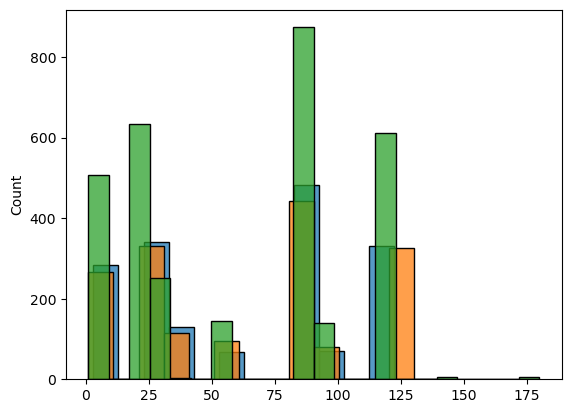

In [66]:
import seaborn as sns

top_n = 5
for name, gdata in group_data:
    gidc = gdata.index
    logging.info(f'{name}')
    pred = np.argsort(per_class_predictions.loc[gidc,:], axis=1)[:,-top_n:]
    sns.histplot(pred.ravel(), legend=True)

In [34]:
test_adata.obs.scanvi_predictions.str.split(';').str[-1].value_counts()

scanvi_predictions
FASTKD5    919
TSR2       361
TRA2B       20
INTS8        8
Name: count, dtype: int64